# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from matplotlib.colors import Normalize
import networkx as nx
from scipy.signal import welch
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA

# Utils

In [ ]:
def scale_spectral_radius(W, target_radius=0.95):
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [ ]:
def hyperbolic_distance_poincare(u, v):
    """
    Compute the hyperbolic distance d(u, v) in the Poincaré disk model (2D).
    Both u, v in R^2 with ||u|| < 1, ||v|| < 1.
    Formula: 
      d(u,v) = arcosh(1 + 2 * ||u - v||^2 / ((1 - ||u||^2)*(1 - ||v||^2)))
    If either point is near radius=1, numerical instability might occur. 
    """

    norm_u_squared = np.dot(u, u)
    norm_v_squared = np.dot(v, v)
    
    # clamp to avoid negative denominators if norms ~1
    eps = 1e-14
    one_minus_u = max(eps, 1.0 - norm_u_squared)
    one_minus_v = max(eps, 1.0 - norm_v_squared)
    
    diff = u - v
    diff_squared = np.dot(diff, diff)  # Euclidean squared
    
    arg = 1.0 + 2.0 * diff_squared / (one_minus_u * one_minus_v)
    if arg < 1.0:
        arg = 1.0
    return np.arccosh(arg)

In [ ]:
def plot_poincare_geodesic(p, q, ax, n_points=200, **kw):
    """
    Plot a geodesic between two points p and q on the Poincaré disk.
    
    Parameters:
    - p, q: np.array of shape (2,), points in the Poincaré disk
    - ax: matplotlib axis to plot on
    - n_points: number of points to use for the geodesic arc
    - **kw: keyword arguments passed to ax.plot
    
    Returns:
    - None, plots the geodesic on the given axis
    """
    
    # Ensure points are within the disk
    p_norm = np.linalg.norm(p)
    q_norm = np.linalg.norm(q)
    if p_norm >= 1.0 or q_norm >= 1.0:
        raise ValueError("Points must be within the unit disk")
    
    # Check if points are on a diameter (geodesic is a straight line)
    if np.isclose(np.linalg.norm(np.cross(np.append(p, 0), np.append(q, 0))), 0):
        ax.plot([p[0], q[0]], [p[1], q[1]], **kw)
        return
    
    # For non-diametric geodesics, we need to find the circle
    # orthogonal to the unit circle and passing through p and q
    
    # Möbius transformation approach
    x1, y1 = p
    x2, y2 = q
    
    # Calculate circle parameters
    # We're looking for a circle that is orthogonal to the unit circle
    # and passes through p and q
    
    # This is a circle with center c and radius r such that:
    # |c|^2 - r^2 = 1 (orthogonality condition)
    # |p - c|^2 = r^2 and |q - c|^2 = r^2 (p and q are on the circle)
    
    # Set up the linear system for finding the center
    A = np.array([
        [2*(x2 - x1), 2*(y2 - y1)],
        [2*x1, 2*y1]
    ])
    
    b = np.array([
        x2**2 + y2**2 - x1**2 - y1**2,
        1 + x1**2 + y1**2
    ])
    
    # Solve for the center c
    try:
        c = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        # If the system is singular, the points are on a straight line through the origin
        ax.plot([p[0], q[0]], [p[1], q[1]], **kw)
        return
    
    # Calculate radius
    r = np.sqrt(np.sum((p - c)**2))
    
    # Determine the angles for the arc
    theta1 = np.arctan2(p[1] - c[1], p[0] - c[0])
    theta2 = np.arctan2(q[1] - c[1], q[0] - c[0])
    
    # Ensure we take the shortest path (the arc that stays within the disk)
    # The key insight: we want the arc that stays inside the unit disk
    delta_theta = (theta2 - theta1) % (2 * np.pi)
    if delta_theta > np.pi:
        delta_theta = delta_theta - 2 * np.pi
    
    # If the center is far away, we might need to reverse the direction
    # to ensure we stay inside the unit disk
    mid_theta = theta1 + delta_theta/2
    mid_point = c + r * np.array([np.cos(mid_theta), np.sin(mid_theta)])
    if np.linalg.norm(mid_point) > 1:
        delta_theta = -delta_theta
    
    # Generate points along the arc
    thetas = np.linspace(theta1, theta1 + delta_theta, n_points)
    arc_points = c.reshape(2, 1) + r * np.vstack([np.cos(thetas), np.sin(thetas)])
    
    # Filter points to ensure they're within the unit disk
    mask = (arc_points[0]**2 + arc_points[1]**2) < 1 - 1e-10
    
    # Plot the geodesic arc
    ax.plot(arc_points[0, mask], arc_points[1, mask], **kw)
    
    return arc_points[:, mask]


def draw_hyperbolic_reservoir(positions, W, save_path="Figures/hyperbolic_reservoir.png"):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_frame_on(False)
    ax.add_patch(plt.Circle((0, 0), 1, color='black', fill=False, linestyle='dashed'))

    radial_distances = np.linalg.norm(positions, axis=1)
    norm = Normalize(vmin=0, vmax=np.max(radial_distances))
    cmap = plt.get_cmap("twilight_r")

    G = nx.Graph()
    N = len(positions)
    for i in range(N):
        G.add_node(i, pos=positions[i])
    
    
    for i in range(N):
        for j in range(N):
            if W[i, j] > 0:
                # Use _plot_geodesic to draw hyperbolic geodesic path
                p = positions[i]
                q = positions[j]
                plot_poincare_geodesic(p, q, ax, color=(0, 49/255, 83/255, min(W[i, j]*300.0, 1.0)))

    for i in range(N):
        ax.scatter(positions[i, 0], positions[i, 1], color=cmap(0.97), s=50, edgecolors='k', linewidth=0.5, zorder=2)

    # sm = ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label("Radial Distance")
    
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


In [ ]:
def plot_pca_projection3d(states):
    # Apply PCA for 3D visualization
    pca = PCA(n_components=3)
    proj = pca.fit_transform(states)

    sns.set_theme(style="white")
    fig = plt.figure(figsize=(12, 9))  # Increased width for padding
    ax = plt.axes(projection='3d')

    # Scatter plot
    p = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], 
                   c=np.arange(len(proj)), cmap='viridis', s=2.5)

    # Axis labels with padding
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label("Index progression")
    
    plt.savefig('Figures/PCA_projection_2d_rossler_hyper.png', dpi=600)
    plt.show()

In [ ]:
def plot_pca_projection2d(states):
    # Apply PCA for 3D visualization
    pca = PCA(n_components=2)
    proj = pca.fit_transform(states)

    sns.set_theme(style="white")
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    p = ax.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap='plasma', s=2.5)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    plt.savefig('Figures/PCA_projection_3d_rossler_hyper.png', dpi=600)
    plt.show()

In [ ]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

def visualize_sparsity(matrix1, matrix2):
        combined = np.stack([matrix1, matrix2])
        min_nonzero = np.min(combined[combined > 0])
        small_value = min_nonzero / 1000
        vmax = np.max(combined)
        norm = colors.LogNorm(vmin=small_value, vmax=vmax)

        # Setup figure and gridspec
        fig = plt.figure(figsize=(20, 8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        cbar_ax = plt.subplot(gs[2])  # This will span the full vertical height

        # Plot first matrix
        sns.heatmap(matrix1, cmap='twilight', ax=ax1, norm=norm, mask=(matrix1 == 0), cbar=False)
        ax1.axis('off')

        # Plot second matrix
        sns.heatmap(matrix2, cmap='twilight', ax=ax2, norm=norm, mask=(matrix2 == 0),
                        cbar=True, cbar_ax=cbar_ax)
        ax2.axis('off')
        plt.savefig('Figures/Sparsity Visualization.png', dpi=600)
        plt.show()

In [ ]:
def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb

# Baselines

In [ ]:
def scale_spectral_radius(W, target_radius=0.95):
    """
    Scales a matrix W so that its largest eigenvalue magnitude = target_radius.
    """
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1

### Baseline ESN

In [ ]:
class ESN3D:
    """
    Dense random ESN for 3D->3D single-step.
    Teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W = np.random.randn(reservoir_size, reservoir_size)*0.1
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale
        # self.W_in = np.random.uniform(-self.input_scale, self.input_scale, (reservoir_size, 3))

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


### SCR

In [ ]:
class CR3D:
    """
    Cycle (ring) reservoir for 3D->3D single-step,
    teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = 1.0
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W
        
        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


### CRJ

In [ ]:
class CRJ3D:
    """
    Cycle Reservoir with Jumps (CRJ) for 3D->3D single-step tasks.
    We form a ring adjacency with an extra 'jump' edge in each row.
    This can help capture multiple timescales or delayed memory
    while retaining the easy ring structure.

    The adjacency is built as follows (reservoir_size = mod N):
      For each i in [0..N-1]:
        W[i, (i+1) % mod N] = 1.0
        W[i, (i+jump) % mod N] = 1.0
    Then we scale by 'spectral_radius.' We do an ESN update
    with readout [ x, x^2, 1 ] -> next step in R^3.
    """

    def __init__(self,
                 reservoir_size=300,
                 jump=10,                # offset for the jump
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        reservoir_size: how many nodes in the ring
        jump            : the offset for the 2nd connection from node i
        spectral_radius : scale adjacency
        input_scale     : scale factor for W_in
        leaking_rate    : ESN 'alpha'
        ridge_alpha     : ridge penalty for readout
        seed            : random seed
        """
        self.reservoir_size = reservoir_size
        self.jump = jump
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        # build adjacency
        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            # cycle edge: i -> (i+1)%N
            W[i, (i+1) % reservoir_size] = 1.0
            # jump edge: i -> (i+jump)%N
            W[i, (i + self.jump) % reservoir_size] = 1.0

        # scale spectral radius
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        # input weights => shape [N,3]
        np.random.seed(self.seed+100)
        W_in = (np.random.rand(reservoir_size, 3) - 0.5)*2.0*self.input_scale
        self.W_in = W_in

        # readout
        self.W_out = None
        self.x = np.zeros(self.reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single-step ESN update:
          x(t+1) = (1-alpha)*x(t) + alpha*tanh( W x(t) + W_in u(t) )
        """
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => feed the real 3D inputs => gather states.
        Return (states_after_discard, states_discarded).
        """
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        gather states => polynomial readout => solve ridge
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list = []
        for s in states_use:
            # polynomial expansion => [ x, x^2, 1 ]
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out = reg.coef_  # shape => (3, 2N+1)

    def predict_autoregressive(self, initial_input, n_steps):
        """
        fully autoregressive => feed last output => next input
        """
        preds = []
        #self.reset_state()
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            big_x = augment_state_with_squares(self.x)
            out = self.W_out @ big_x  # shape => (3,)
            preds.append(out)
            current_in = out
        return np.array(preds)
        
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

# SparseESN

In [ ]:
class SparseESN3D:
    """
    Sparse random ESN for 3D->3D single-step,
    teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 connectivity=0.05,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W_full = np.random.randn(reservoir_size, reservoir_size)*0.1
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W_full * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)

### Small-World Res

In [ ]:
# --- Revised segregated IO reservoir class ---
class SW3DSegregated:
    """
    Segregated IO small-world reservoir with spatial embedding.
    
    The reservoir is partitioned into three segments:
      - Input group: nodes that receive external input.
      - Core group: intermediate hidden nodes.
      - Output group: nodes from which the readout is taken.
    
    Total nodes = 500:
      - 100 Input nodes are clustered (angles in [-delta, delta])
      - 100 Output nodes are clustered (angles in [pi-delta, pi+delta])
      - 300 Core nodes are distributed evenly over the remaining circle.
    
    Connectivity is generated over the sorted order (by angular position) using
    a regular ring (nearest neighbor) scheme with random rewiring (Watts–Strogatz style).
    """
    def __init__(self,
                 reservoir_size=500,
                 edges_per_node=6,            # Must be even (here 6: 3 forward, 3 backward)
                 input_reservoir_size=100,      # Number of input nodes
                 output_reservoir_size=100,     # Number of output nodes
                 rewiring_probability=0.1,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=48):
        # Save parameters
        self.reservoir_size = reservoir_size
        self.edges_per_node = edges_per_node
        self.input_res_size = input_reservoir_size
        self.output_res_size = output_reservoir_size
        self.core_res_size = reservoir_size - (input_reservoir_size + output_reservoir_size)
        self.rewiring_probability = rewiring_probability
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed
        
        np.random.seed(self.seed+1)
        
        # --- Assign spatial positions to nodes (angular embedding on a circle) ---
        # Define width for the input/output clusters.
        delta = np.pi / 20  # small angular window (≈9°)
        n_in = self.input_res_size
        n_out = self.output_res_size
        n_core = self.core_res_size
        
        # Input nodes: angles uniformly in [-delta, delta]
        input_positions = np.random.uniform(-delta, delta, size=n_in)
        # Output nodes: angles uniformly in [pi-delta, pi+delta]
        output_positions = np.random.uniform(np.pi - delta, np.pi + delta, size=n_out)
        
        # Core nodes: distribute them evenly over the remaining parts of the circle.
        # For clarity, we divide the remainder into two arcs.
        n_core1 = n_core // 2
        n_core2 = n_core - n_core1
        # Arc 1: from delta to (pi - delta)
        core_positions1 = np.linspace(delta, np.pi - delta, n_core1, endpoint=False)
        # Arc 2: from (pi + delta) to (2*pi - delta)
        core_positions2 = np.linspace(np.pi + delta, 2*np.pi - delta, n_core2, endpoint=False)
        core_positions = np.concatenate([core_positions1, core_positions2])
        
        # Concatenate all positions and assign labels:
        # 0 for input; 1 for core; 2 for output.
        self.positions = np.concatenate([input_positions, core_positions, output_positions])
        self.labels = np.concatenate([np.zeros(n_in, dtype=int),
                                       np.ones(n_core, dtype=int),
                                       2*np.ones(n_out, dtype=int)])
        
        # Sort nodes by angular position so they lie along a ring.
        sort_order = np.argsort(self.positions)
        self.positions = self.positions[sort_order]
        self.labels = self.labels[sort_order]
        self.all_indices = np.arange(self.reservoir_size)
        
        # Determine indices for each group after sorting.
        self.input_indices = np.where(self.labels == 0)[0]
        self.core_indices = np.where(self.labels == 1)[0]
        self.output_indices = np.where(self.labels == 2)[0]
        
        # --- Create input weight matrix (applied only to input nodes) ---
        # Assuming external input is 3-dimensional.
        self.W_in = (np.random.rand(len(self.input_indices), 3) - 0.5) * self.input_scale
        
        # Initialize output weight (readout) and reservoir state vector.
        self.W_out = None
        self.x = np.zeros(self.reservoir_size)
        
        # --- Build reservoir connectivity using the sorted (ring) order ---
        # We use a simple ring-based connection: for each node, connect to its
        # nearest neighbors (with offsets 1 to edges_per_node/2) in each direction.
        W = np.zeros((self.reservoir_size, self.reservoir_size))
        half_edges = self.edges_per_node // 2
        for i in range(self.reservoir_size):
            for offset in range(1, half_edges + 1):
                j = (i + offset) % self.reservoir_size
                k = (i - offset) % self.reservoir_size
                W[i, j] = 1.0
                W[i, k] = 1.0
        
        # --- Apply random rewiring (Watts–Strogatz) across all nodes ---
        for i in range(self.reservoir_size):
            current_neighbors = np.where(W[i] == 1.0)[0]
            for j in current_neighbors:
                if np.random.rand() < self.rewiring_probability:
                    W[i, j] = 0.0
                    # Ensure new connection does not duplicate an existing link
                    possible_nodes = list(set(self.all_indices) - {i} - set(np.where(W[i] == 1.0)[0]))
                    if possible_nodes:
                        new_j = np.random.choice(possible_nodes)
                        W[i, new_j] = 1.0
                        
        # Scale the reservoir connectivity to have the desired spectral radius.
        self.W = scale_spectral_radius(W, self.spectral_radius)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Update the reservoir state vector x.
          - The recurrent contribution is computed via W @ x.
          - The external input u (a 3D vector) is added only to input nodes (via W_in).
          - A tanh nonlinearity and leaky integration are applied.
        """
        recurrent = self.W @ self.x
        ext_input = np.zeros(self.reservoir_size)
        # Apply external input only to nodes in the input group.
        for idx, node in enumerate(self.input_indices):
            ext_input[node] = self.W_in[idx] @ u
        pre_activation = recurrent + ext_input
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha) * self.x + alpha * x_new

    def collect_states(self, inputs, discard=100):
        """
        Run the reservoir over an input sequence.
          - The external input drives only the input nodes.
          - States from the output nodes are recorded (after a washout period).
        Returns:
          - output_states: a T x (# output nodes) array (post-discard).
          - discard_states: states corresponding to the washout period.
        """
        self.reset_state()
        all_states = []
        for u in inputs:
            self._update(u)
            all_states.append(self.x.copy())
        all_states = np.array(all_states)
        output_states = all_states[:, self.output_indices]
        return output_states[discard:], output_states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Train the linear readout on teacher-forced reservoir states.
        Only states from the output nodes (the segregated readout cluster)
        are used. A polynomial (squares) expansion and a bias term are
        applied before ridge regression.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        X_list = [augment_state_with_squares(s) for s in states_use]
        X_aug = np.array(X_list)  # Shape: [T-discard, 2*len(output_indices) + 1]
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        """
        Generate predictions in closed-loop (autoregressive) mode.
          - At each step, update the reservoir.
          - Compute the readout using only the output node states.
          - The prediction becomes the next input.
        """
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            x_out = self.x[self.output_indices]
            x_aug = augment_state_with_squares(x_out)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)
    
    def predict_open(self, test_input):
        preds = []
        for u in test_input:
            self._update(u)
            x_out = self.x[self.output_indices]
            x_aug = augment_state_with_squares(x_out)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


# --- Random IO Reservoir Class ---
class SW3DRandom:
    """
    Random IO small-world reservoir for 3D->3D mapping.
    
    In this version:
      - Total reservoir nodes: reservoir_size (default 500)
      - Input nodes: a subset of reservoir nodes (default 100) chosen at random.
      - Output nodes: a disjoint subset of reservoir nodes (default 100) chosen at random.
      - The remaining nodes (core nodes) are the other 300 nodes.
    
    The recurrent connectivity is created using a ring-based nearest-neighbor scheme (with edges_per_node
    number of connections per node) and then rewired randomly with a given rewiring probability.
    
    The external input (assumed 3-dimensional) is injected only on the input nodes (via W_in),
    and the output is read only from the output nodes.
    """
    def __init__(self,
                 reservoir_size=500,
                 edges_per_node=6,              # Must be even (here: 3 neighbors forward, 3 backward)
                 input_reservoir_size=100,        # Number of input nodes
                 output_reservoir_size=100,       # Number of output nodes
                 rewiring_probability=0.1,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=48):
        # Save parameters
        self.reservoir_size = reservoir_size
        self.edges_per_node = edges_per_node
        self.input_res_size = input_reservoir_size
        self.output_res_size = output_reservoir_size
        self.core_res_size = reservoir_size - (input_reservoir_size + output_reservoir_size)
        self.rewiring_probability = rewiring_probability
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed+1)
        total_indices = np.arange(self.reservoir_size)
        # Randomly choose indices for IO nodes without overlapping.
        all_io = np.random.choice(total_indices, size=(self.input_res_size + self.output_res_size), replace=False)
        np.random.shuffle(all_io)
        self.input_indices = all_io[:self.input_res_size]
        self.output_indices = all_io[self.input_res_size:self.input_res_size + self.output_res_size]
        # The core indices are the remaining ones
        self.core_indices = np.array(list(set(total_indices) - set(self.input_indices) - set(self.output_indices)))
        
        # --- Create Input Weight Matrix ---
        # Only input nodes receive external input; input is assumed 3-dimensional.
        self.W_in = (np.random.rand(len(self.input_indices), 3) - 0.5) * self.input_scale

        # Initialize output weight (readout) and reservoir state vector.
        self.W_out = None
        self.x = np.zeros(self.reservoir_size)
        
        # --- Build reservoir connectivity ---
        # Use a ring-based connectivity in the natural (index) order.
        # Each node i will be connected to its nearest half_edges neighbors in both directions.
        W = np.zeros((self.reservoir_size, self.reservoir_size))
        half_edges = self.edges_per_node // 2
        for i in range(self.reservoir_size):
            for offset in range(1, half_edges + 1):
                j = (i + offset) % self.reservoir_size
                k = (i - offset) % self.reservoir_size
                W[i, j] = 1.0
                W[i, k] = 1.0

        # --- Random rewiring (Watts-Strogatz style) ---
        for i in range(self.reservoir_size):
            current_neighbors = np.where(W[i] == 1.0)[0]
            for j in current_neighbors:
                if np.random.rand() < self.rewiring_probability:
                    W[i, j] = 0.0
                    possible_nodes = list(set(range(self.reservoir_size)) - {i} - set(np.where(W[i] == 1.0)[0]))
                    if possible_nodes:
                        new_j = np.random.choice(possible_nodes)
                        W[i, new_j] = 1.0

        # Scale the reservoir weight matrix to have the desired spectral radius.
        self.W = scale_spectral_radius(W, self.spectral_radius)
    
    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)
    
    def _update(self, u):
        """
        Update the reservoir state.
          - The recurrent input is W @ x.
          - External input u (3D) is added only at input nodes.
          - A tanh nonlinearity and leaky integration update the state.
        """
        recurrent = self.W @ self.x
        ext_input = np.zeros(self.reservoir_size)
        for idx, node in enumerate(self.input_indices):
            ext_input[node] = self.W_in[idx] @ u
        pre_activation = recurrent + ext_input
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha) * self.x + alpha * x_new
    
    def collect_states(self, inputs, discard=100):
        """
        Drive the reservoir with a sequence of inputs and record the states.
        Only the states of the output nodes are kept for the readout.
        """
        self.reset_state()
        all_states = []
        for u in inputs:
            self._update(u)
            all_states.append(self.x.copy())
        all_states = np.array(all_states)
        output_states = all_states[:, self.output_indices]
        return output_states[discard:], all_states[:discard]
    
    def fit_readout(self, train_input, train_target, discard=100):
        """
        Train the readout weights from the reservoir.
          - The readout is based on states from output nodes.
          - Each state is augmented (with squared values and bias) before Ridge regression.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        X_list = [augment_state_with_squares(s) for s in states_use]
        X_aug = np.array(X_list)
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_
    
    def predict_autoregressive(self, initial_input, n_steps):
        """
        Generate predictions in an autoregressive manner.
          - At each step, the reservoir is updated with the current input.
          - The output is computed solely from the output nodes.
          - The predicted output is used as the next input.
        """
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            x_out = self.x[self.output_indices]
            x_aug = augment_state_with_squares(x_out)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)
    
    def predict_open(self, test_input):
        preds = []
        for u in test_input:
            self._update(u)
            x_out = self.x[self.output_indices]
            x_aug = augment_state_with_squares(x_out)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

### MCI-ESN

In [ ]:
class MCI3D:
    """
    Minimum Complexity Interaction ESN (MCI-ESN).

    This class implements the approach described in:
      "A Minimum Complexity Interaction Echo State Network"
        by Jianming Liu, Xu Xu, Eric Li (2024).
    
    The model structure:
      - We maintain two 'simple cycle' reservoirs (each of size N).
      - Each reservoir is a ring with weight = l, i.e. 
            W_res[i, (i+1)%N] = l
        plus the corner wrap from (N-1)->0, also = l. ##(unnecessary as already called for in the prev. line)
      - The two reservoirs interact via a minimal connection matrix: 
         exactly 2 cross-connections with weight = g. 
         (One might connect x2[-1], x2[-2], ... 
          But we do where reservoir1 sees x2[-1] 
          in one location, and reservoir2 sees x1[-1] likewise.)
      - Activation function in reservoir1 is cos(·), and in reservoir2 is sin(·).
      - They each have a separate input weight matrix: Win1 and Win2. 
        The final state is a linear combination 
           x(t) = h*x1(t) + (1-h)*x2(t).
      - Then we do a polynomial readout [x, x^2, 1] -> output.
      - We feed teacher forcing in collect_states, 
        then solve readout with Ridge regression.

    References:
      - Liu, J., Xu, X., & Li, E. (2024). 
        "A minimum complexity interaction echo state network," 
         Neural Computing and Applications.
    
    notes:
      - The reservoir_size is N for each reservoir, 
        so total param dimension is 2*N for states, 
        but we produce a single final "combined" state x(t) in R^N for readout.
      - The activation f1=cos(...) for reservoir1, f2=sin(...) for reservoir2, 
        as recommended by the paper for MCI-ESN.

    """

    def __init__(
        self,
        reservoir_size=500,
        cycle_weight=0.9,      # 'l' in the paper
        connect_weight=0.9,    # 'g' in the paper
        input_scale=0.2,
        leaking_rate=1.0,
        ridge_alpha=1e-6,
        combine_factor=0.1,    # 'h' in the paper
        seed=47,
        v1=0.6, v2=0.6         # fixed values for v1, v2
    ):
        """
        reservoir_size: N, size of each cycle reservoir 
        cycle_weight : l, ring adjacency weight in [0,1), ensures cycle synergy
        connect_weight: g, cross-connection weight between the two cycle reservoirs
        input_scale   : scale factor for input->reservoir weights
        leaking_rate  : ESN update alpha 
        ridge_alpha   : readout ridge penalty
        combine_factor: h in [0,1], to form x(t)= h*x1(t)+(1-h)*x2(t) as final combined state
        seed          : random seed
        """
        self.reservoir_size = reservoir_size
        self.cycle_weight   = cycle_weight
        self.connect_weight = connect_weight
        self.input_scale    = input_scale
        self.leaking_rate   = leaking_rate
        self.ridge_alpha    = ridge_alpha
        self.combine_factor = combine_factor
        self.seed           = seed
        self.v1 = v1
        self.v2 = v2

        # We'll define (and build) adjacency for each cycle, 
        # plus cross-connection for two sub-reservoirs.
        # We'll define 2 input weight mats: Win1, Win2.
        # We'll define states x1(t), x2(t).
        # We'll define readout W_out after training.

        self._build_mci_esn()

    def _build_mci_esn(self):
        """
        Build all the internal parameters: 
         - ring adjacency for each reservoir
         - cross-reservoir connection
         - input weights for each reservoir
         - initial states
        """
        np.random.seed(self.seed)

        N = self.reservoir_size

        # Build ring adjacency W_res in shape [N, N], with cycle_weight on ring
        W_res = np.zeros((N, N))
        for i in range(N):
            j = (i+1) % N
            W_res[j, i] = self.cycle_weight
        self.W_res = W_res  # shared by both sub-reservoirs

        # Build cross-connection W_cn for shape [N,N], 
        # minimal 2 nonzero elements. 
        # For the simplest approach from the paper:
        #   W_cn[0, N-1] = g, W_cn[1, N-2] = g or similar.
        # The paper's eq(7) suggests the last 2 elements in x(t) cross to first 2 in the other reservoir:
        # We'll do the simplest reference: if i=0 or i=1, we connect from the other reservoir's last or second-last. 
        # We'll define a function for each sub-res to pick up from the other sub-res. 
        # We can store them in separate arrays, or define them in code. 
        # We'll just store "We want index 0 to see x2[-1], index 1 to see x2[-2]."

        # But as done in the original code snippet from the paper:
        #   Wcn has
        # effectively 2 nonzero positions. We'll define that pattern:
        W_cn = np.zeros((N, N))
        # e.g. W_cn[0, N-1] = g, W_cn[N-1, N-2] = g or something. 
        # The paper example used W_cn = diag(0,g,...) plus the corner. We'll do the simplest:
        # let W_cn[0, N-1]=g, W_cn[1, N-2]=g.
        # This matches the minimal cross. 
        # For clarity we do:
        W_cn[0, N-1] = self.connect_weight
        if N>1:
            # W_cn[1, N-2] = self.connect_weight
            W_cn[N-1, 0] = self.connect_weight
        self.W_cn = W_cn

        # We'll define input weights for each sub-reservoir, shape [N, dim_input].
        # The paper sets them as eq(10) in the snippet, with different signs. 
        # We'll define them as parted. 
        # We define V1, V2 => shape [N, dim_input], with constant magnitude t1, t2, random sign. 
        # We'll do random. Need to check this in the paper again
        # We'll keep "two" separate. user can define input_scale but not two separate. 
        # We'll do the simplest approach: the absolute value is the same => input_scale, 
        # sign is random. Then we define Win1 = V1 - V2, Win2 = V1 + V2.
        # This is consistent with eq(10) from the paper.

        self.Win1 = None
        self.Win2 = None

        # We'll define states x1(t), x2(t). We'll do them after dimension known. 
        self.x1 = None
        self.x2 = None

        self.W_out = None

    def _init_substates(self):
        """
        Once we know reservoir_size, we define x1, x2 as zeros. 
        We'll call this in reset_state or at fit time.
        """
        N = self.reservoir_size
        self.x1 = np.zeros(N)
        self.x2 = np.zeros(N)

    def reset_state(self):
        if self.x1 is not None:
            self.x1[:] = 0.0
        if self.x2 is not None:
            self.x2[:] = 0.0

    def _update(self, u):
        """
        Single-step reservoir update.
        x1(t+1) = cos( Win1*u(t+1) + W_res*x1(t) + W_cn*x2(t) )
        x2(t+1) = sin( Win2*u(t+1) + W_res*x2(t) + W_cn*x1(t) )
        Then x(t)= h*x1(t+1) + (1-h)* x2(t+1).
        We'll define the leaky integration. 
        But the paper uses an approach with no leak? Be careful.
        We'll do the approach: x1(t+1)= (1-alpha)* x1(t) + alpha*cos(...).
        """
        alpha = self.leaking_rate

        # pre activation for reservoir1
        pre1 = self.Win1 @ u + self.W_res @ self.x1 + self.W_cn @ self.x2
        # reservoir1 uses cos
        new_x1 = np.cos(pre1)

        # reservoir2 uses sin
        pre2 = self.Win2 @ u + self.W_res @ self.x2 + self.W_cn @ self.x1
        new_x2 = np.sin(pre2)

        self.x1 = (1.0 - alpha)*self.x1 + alpha*new_x1
        self.x2 = (1.0 - alpha)*self.x2 + alpha*new_x2

    def _combine_state(self):
        """
        Combine x1(t), x2(t) => x(t) = h*x1 + (1-h)*x2
        """
        h = self.combine_factor
        return h*self.x1 + (1.0 - h)*self.x2

    def collect_states(self, inputs, discard=100):
        # We reset the reservoir to zero
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])   # feed the REAL input from the dataset
            combined = self._combine_state()
            states.append(combined.copy())
        states = np.array(states)  # shape => [T, N]
        return states[discard:], states[:discard]


    def fit_readout(self, train_input, train_target, discard=100):
        """
        Build input weights if needed, gather states on the training data (teacher forcing),
        then solve a polynomial readout [x, x^2, 1]->train_target(t).

        train_input : shape [T, d_in]
        train_target: shape [T, d_out]
        discard     : # of states to discard for warmup
        """
        T = len(train_input)
        if T<2:
            raise ValueError("Not enough training data")

        d_in = train_input.shape[1]
        # d_out = train_target.shape[1]

        # built Win1, Win2
        if self.Win1 is None or self.Win2 is None:
            np.random.seed(self.seed+100)
            # build V1, V2 in shape [N, d_in]
            N = self.reservoir_size
            # V1 = (np.random.rand(N, d_in)-0.5)*2.0*self.input_scale
            # V2 = (np.random.rand(N, d_in)-0.5)*2.0*self.input_scale

            sign_V1 = np.random.choice([-1, 1], size=(N, d_in))
            sign_V2 = np.random.choice([-1, 1], size=(N, d_in))

            v1, v2 = self.v1, self.v2  # fixed values for V1, V2

            V1 = v1 * sign_V1 * self.input_scale
            V2 = v2 * sign_V2 * self.input_scale

            # eq(10): Win1= V1 - V2, Win2= V1 + V2
            self.Win1 = V1 - V2
            self.Win2 = V1 + V2

        # define x1, x2
        self._init_substates()

        # gather states
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]  # shape => [T-discard, d_out]

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        # Solve ridge
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        # W_out => shape [d_out, 2N+1]
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        """
        Fully autoregressive: 
          We do not use teacher forcing, 
          we feed the model's last output as the next input 
        Typically, for MCI-ESN the paper does input(t+1) in R^d. 
        We do the test_input
        For multi-step chaotic forecast, we feed the model's output as input? 
        That means the system dimension d_in must match d_out. 
        """
        preds = []
        # re-init states
        #self._init_substates()

        # we assume initial_input => shape (d_in,)
        current_in = np.array(initial_input)

        for _ in range(n_steps):
            self._update(current_in)
            # read out
            combined = self._combine_state()
            big_x = augment_state_with_squares(combined)
            out = self.W_out @ big_x  # shape => (d_out,)

            preds.append(out)
            current_in = out  # feed output back as next input

        return np.array(preds)
        
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            combined = self._combine_state()
            x_aug = augment_state_with_squares(combined)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

# HFR

In [ ]:
class HFRRes3D:
    """
    Hierarchical Fractal Reservoir (HFR) for 3D chaotic systems.
    
    This novel reservoir architecture partitions the chaotic attractor at multiple
    hierarchical scales, combining them in a fractal-like adjacency structure.
    The method is model-free, relying solely on the observed trajectory in R^3,
    and does not require knowledge of any system parameters such as sigma, rho, beta
    for Lorenz63. 
    
    Key Idea:
     1) Define multiple 'scales' of partition of the data's bounding region.
     2) Each scale is subdivided into a certain number of cells (regions).
     3) Each cell at level l has links to both:
        - other cells at the same level (horizontal adjacency),
        - 'child' cells at the finer level l+1 (vertical adjacency).
     4) We gather all cells across levels => a multi-level fractal graph => adjacency => W.
     5) We build a typical ESN from this adjacency, feed data with W_in, run leaky tanh updates,
        then do a polynomial readout for 3D next-step prediction.

    This approach is suitable for chaotic systems whose attractors often exhibit fractal
    self-similarity, thus capturing multi-scale structures in a single reservoir.
    """

    def __init__(self,
                 n_levels=3,             # number of hierarchical levels
                 cells_per_level=None,   # list of number of cells at each level, e.g. [8, 32, 128]
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        Parameters
        ----------
        n_levels       : int, number of hierarchical scales
        cells_per_level: list[int], the number of partitions/cells at each level
                         if None, we auto-generate e.g. 2^(level+2)
        spectral_radius: final scaling for adjacency
        input_scale    : random input scale W_in
        leaking_rate   : ESN leaky alpha
        ridge_alpha    : readout ridge penalty
        seed           : random seed
        """
        self.n_levels        = n_levels
        self.cells_per_level = cells_per_level
        self.spectral_radius = spectral_radius
        self.input_scale     = input_scale
        self.leaking_rate    = leaking_rate
        self.ridge_alpha     = ridge_alpha
        self.seed            = seed

        if self.cells_per_level is None:
            # default scheme e.g. 8, 16, 32 for 3 levels
            self.cells_per_level = [8*(2**i) for i in range(n_levels)]

        # We'll store adjacency W, input W_in, readout W_out, reservoir state x
        self.W     = None
        self.W_in  = None
        self.W_out = None
        self.x     = None
        self.n_levels = len(self.cells_per_level)

        # We'll define a total number of nodes = sum(cells_per_level)
        self.n_nodes = sum(self.cells_per_level)

    def _build_partitions(self, data_3d):
        """
        Build hierarchical partitions for each level.
        We'll store the bounding box for data_3d, then for each level l in [0..n_levels-1]
        run e.g. k-means with K = cells_per_level[l], each point gets a label => we track transitions.

        Return: 
          partitions => list of arrays, partitions[l] => shape (N, ) cluster assignment in [0..cells_per_level[l]-1]
        """
        from sklearn.cluster import KMeans
        N = len(data_3d)
        partitions = []

        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            # cluster
            kmeans = KMeans(n_clusters=k, random_state=self.seed+10*level, n_init='auto')
            kmeans.fit(data_3d)
            labels = kmeans.predict(data_3d)
            partitions.append(labels)

        return partitions

    def _build_hierarchical_adjacency(self, data_3d):
        """
        Build a block adjacency with cross-level links, then scale spectral radius.
        Steps:
          1) Build partitions for each level => partitions[l] in [0..cells_per_level[l]-1]
          2) For each level l, build a transition matrix T_l of shape (cells_per_level[l], cells_per_level[l]).
          3) Link scale l to scale l+1 by figuring out which cluster i at scale l maps to which cluster j at scale l+1
             for each sample t => link i-> j if data_3d[t] is in i at scale l and j at scale l+1.
          4) Combine all transitions in one big adjacency W in R^(n_nodes x n_nodes).
          5) row-normalize W => scale largest eigenvalue => spectral_radius
        """
        partitions = self._build_partitions(data_3d)
        N = len(data_3d)

        # offsets for each level => to index big W
        offsets = []
        running = 0
        for level in range(self.n_levels):
            offsets.append(running)
            running += self.cells_per_level[level]

        # total nodes
        n_tot = self.n_nodes
        # initialize adjacency
        A = np.zeros((n_tot, n_tot))

        # 1) horizontal adjacency in each level
        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            labels = partitions[level]
            # T_l => shape (k, k)
            T_l = np.zeros((k, k))
            for t in range(N-1):
                i = labels[t]
                j = labels[t+1]
                T_l[i,j]+=1
            # row normalize
            row_sum = T_l.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            T_l /= row_sum
            # place T_l into big A
            off = offsets[level]
            A[off:off+k, off:off+k] = T_l

        # 2) vertical adjacency between scale l and l+1
        for level in range(self.n_levels-1):
            k_l   = self.cells_per_level[level]
            k_lp1 = self.cells_per_level[level+1]
            labels_l   = partitions[level]
            labels_lp1 = partitions[level+1]
            # we define adjacency from i in [0..k_l-1] to j in [0..k_lp1-1] if the same sample t belongs to i at level l and j at l+1
            # Count how many times
            Xvert1 = np.zeros((k_l, k_lp1))
            for t in range(N):
                i = labels_l[t]
                j = labels_lp1[t]
                Xvert1[i,j]+=1
            # row normalize
            row_sum = Xvert1.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            Xvert = Xvert1/row_sum
            # place in big A
            off_l   = offsets[level]
            off_lp1 = offsets[level+1]
            A[off_l:off_l+k_l, off_lp1:off_lp1+k_lp1] = Xvert
            # tentative idea, we could also define adjacency from l+1 -> l (parent link), if desired
            # we do the same for the 'child -> parent' link or skip it if we only want forward adjacency
            # For now, let's do symmetrical
            Yvert = Xvert1.T
            col_sum = Yvert.sum(axis=1, keepdims=True)
            col_sum[col_sum==0.0] = 1.0
            Yvert /= col_sum
            A[off_lp1:off_lp1+k_lp1, off_l:off_l+k_l] = Yvert

        # now we have a big adjacency => row normalize again, then scale spectral radius
        row_sum = A.sum(axis=1, keepdims=True)
        row_sum[row_sum==0.0] = 1.0
        A /= row_sum

        A = scale_spectral_radius(A, self.spectral_radius)
        return A

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Main training routine:
          1) Build hierarchical adjacency from fractal partition => self.W
          2) define W_in => shape(n_nodes, 3)
          3) teacher forcing => polynomial readout => solve => self.W_out
        """
        np.random.seed(self.seed)
        # Build adjacency
        W_big = self._build_hierarchical_adjacency(train_input)
        self.W = W_big

        # define W_in => shape(n_nodes,3)
        self.n_nodes = W_big.shape[0]
        self.W_in = (np.random.rand(self.n_nodes,3)-0.5)*2.0*self.input_scale

        # define reservoir state
        self.x = np.zeros(self.n_nodes)

        # gather states => teacher forcing => polynomial => readout
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list= []
        for s in states_use:
            X_list.append( augment_state_with_squares(s) )
        X_aug= np.array(X_list)

        reg= Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out= reg.coef_

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => feed real 3D => gather states => shape => [T-discard, n_nodes].
        returns (states_after_discard, states_discarded).
        """
        self.reset_state()
        states= []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states= np.array(states)
        return states[discard:], states[:discard]

    def reset_state(self):
        if self.x is not None:
            self.x.fill(0.0)

    def _update(self, u):
        """
        x(t+1)= (1-alpha)x(t)+ alpha tanh( W*x(t)+ W_in*u(t) ).
        """
        alpha= self.leaking_rate
        pre_acts= self.W@self.x + self.W_in@u
        x_new= np.tanh(pre_acts)
        self.x= (1.0- alpha)*self.x+ alpha*x_new

    def predict_autoregressive(self, initial_input, n_steps):
        """
        fully autonomous => feed last predicted => next input
        """
        preds= []
        #self.reset_state()
        current_in= np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            big_x= augment_state_with_squares(self.x)
            out= self.W_out@big_x
            preds.append(out)
            current_in= out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


# Datasets

### Lorenz System Data Generation

In [ ]:
def lorenz_derivatives(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """Compute time derivatives [dx/dt, dy/dt, dz/dt] for the Lorenz system."""
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [ ]:
def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    """
    Numerically integrate Lorenz equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_derivatives, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

### Rossler System Data Generation

In [ ]:
def rossler_derivatives(state, t, a=0.2, b=0.2, c=5.7):
    """Compute time derivatives [dx/dt, dy/dt, dz/dt] for the Rössler system."""
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

In [ ]:
def generate_rossler_data(
    initial_state=[1.0, 0.0, 0.0],
    tmax=25.0,
    dt=0.01,
    a=0.2,
    b=0.2,
    c=5.7
):
    """
    Numerically integrate Rössler equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(rossler_derivatives, initial_state, t_vals, args=(a, b, c))
    return t_vals, sol

### Chen System Data Generation

In [ ]:
def chen_derivatives(state, t, a=35.0, b=3.0, c=28.0):
    """
    Computes time derivatives [dx/dt, dy/dt, dz/dt] for the Chen system.
    """
    x, y, z = state
    dxdt = a*(y - x)
    dydt = (c - a)*x + c*y - x*z
    dzdt = x*y - b*z
    return [dxdt, dydt, dzdt]

In [ ]:
def generate_chen_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=50.0,
    dt=0.01,
    a=35.0,
    b=3.0,
    c=28.0
):
    """
    Numerically integrate Chen equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(chen_derivatives, initial_state, t_vals, args=(a, b, c))
    return t_vals, sol

### Chua System Data Generation

In [ ]:
def chua_derivatives(state, t, alpha, beta, m0, m1):
    """
    Computes time derivatives [dx/dt, dy/dt, dz/dt] for the Chua system.
    """
    x, y, z = state

    # Nonlinear function h(x)
    h = m1 * x + 0.5 * (m0 - m1) * (np.abs(x + 1) - np.abs(x - 1))

    dxdt = alpha * (y - x - h)
    dydt = x - y + z
    dzdt = -beta * y

    return [dxdt, dydt, dzdt]

In [ ]:
def generate_chua_data(
    initial_state=[0.1, 0.0, 0.0],
    tmax=100.0,
    dt=0.01,
    alpha=15.6,
    beta=28.0,
    m0=-1.143,
    m1=-0.714
):
    """
    Numerically integrate Chua's circuit equations.
    Returns:
        t_vals: array of time points
        sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(chua_derivatives, initial_state, t_vals, args=(alpha, beta, m0, m1))
    return t_vals, sol

## Mackey-Glass Data Generation

In [ ]:
def generate_mackey_glass_data(
    initial_value=0.2,
    tmax=100.0,
    dt=0.01,
    beta=0.2,
    gamma=0.1,
    tau=17
):

    num_steps = int(tmax / dt)
    delay_steps = int(tau / dt)
    t_vals = np.linspace(0, tmax, num_steps)

    # Initialize x with delay
    x = np.zeros(num_steps)
    x[:delay_steps] = initial_value

    for t in range(delay_steps, num_steps):
        x_tau = x[t - delay_steps]
        x[t] = x[t - 1] + dt * (beta * x_tau / (1 + x_tau**10) - gamma * x[t - 1])

    return t_vals, x

# Metrics

### NRMSE

In [ ]:
def evaluate_nrmse(all_preds, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons for Teacher-forced Single-step Forecasting
    """
    horizon_nrmse = {}
    
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        squared_errors = (preds - targets)**2
        variance = np.var(targets, axis=0)
        nrmse = np.sqrt(np.sum(squared_errors) / (horizon * variance))
        horizon_nrmse[horizon] = nrmse

    return horizon_nrmse

### VPT

In [ ]:
def compute_valid_prediction_time(y_true, y_pred, test_time, lyapunov_time, threshold=0.4):
    y_mean = np.mean(y_true, axis=0)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))

    error = y_true - y_pred
    squared_error = np.sum(error**2, axis=1)
    delta = squared_error / denom

    idx_exceed = np.where(delta > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = test_time[-1]
    else:
        T_VPT = test_time[idx_exceed[0]]

    ratio = T_VPT / lyapunov_time

    return T_VPT, ratio

### ADev

In [ ]:
def compute_attractor_deviation(predictions, targets, cube_size=(0.1, 0.1, 0.1)):
    """
    Compute the Attractor Deviation (ADev) metric.

    Parameters:
        predictions (numpy.ndarray): Predicted trajectories of shape (n, 3).
        targets (numpy.ndarray): True trajectories of shape (n, 3).
        cube_size (tuple): Dimensions of the cube (dx, dy, dz).

    Returns:
        float: The ADev metric.
    """
    # Define the cube grid based on the range of the data and cube size
    min_coords = np.min(np.vstack((predictions, targets)), axis=0)
    max_coords = np.max(np.vstack((predictions, targets)), axis=0)

    # Create a grid of cubes
    grid_shape = ((max_coords - min_coords) / cube_size).astype(int) + 1

    # Initialize the cube occupancy arrays
    pred_cubes = np.zeros(grid_shape, dtype=int)
    target_cubes = np.zeros(grid_shape, dtype=int)

    # Map trajectories to cubes
    pred_indices = ((predictions - min_coords) / cube_size).astype(int)
    target_indices = ((targets - min_coords) / cube_size).astype(int)

    # Mark cubes visited by predictions and targets
    for idx in pred_indices:
        pred_cubes[tuple(idx)] = 1
    for idx in target_indices:
        target_cubes[tuple(idx)] = 1

    # Compute the ADev metric
    adev = np.sum(np.abs(pred_cubes - target_cubes))
    return adev

### PSD

In [ ]:
def compute_psd(y, dt=0.01):
    z = y[:, 2]  # Extract Z-component
    
    # Compute PSD using Welch’s method
    freqs, psd = welch(z, fs=1/dt, window='hamming', nperseg=len(z))  # Using Hamming window
    
    return freqs, psd


# Dataset Preparation

### Lorenz System

In [ ]:
tmax = 150.0
dt = 0.02
lorenz_t_vals, lorenz_trajectory = generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0], 
    tmax=tmax,
    dt=dt,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
)

# Discard first 2,000 points as washout
washout = 2000
lorenz_t_vals = lorenz_t_vals[washout:]
lorenz_trajectory = lorenz_trajectory[washout:]

In [ ]:
# # Normalize data
# data_min = lorenz_trajectory.min(axis=0)
# data_max = lorenz_trajectory.max(axis=0)
# lorenz_trajectory = (lorenz_trajectory - data_min) / (data_max - data_min)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight(np.linspace(0, 1, len(lorenz_trajectory)))

for i in range(len(lorenz_trajectory) - 1):
    ax.plot(lorenz_trajectory[i:i+2, 0], lorenz_trajectory[i:i+2, 1], lorenz_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')
plt.savefig("Figures/Lorenz Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

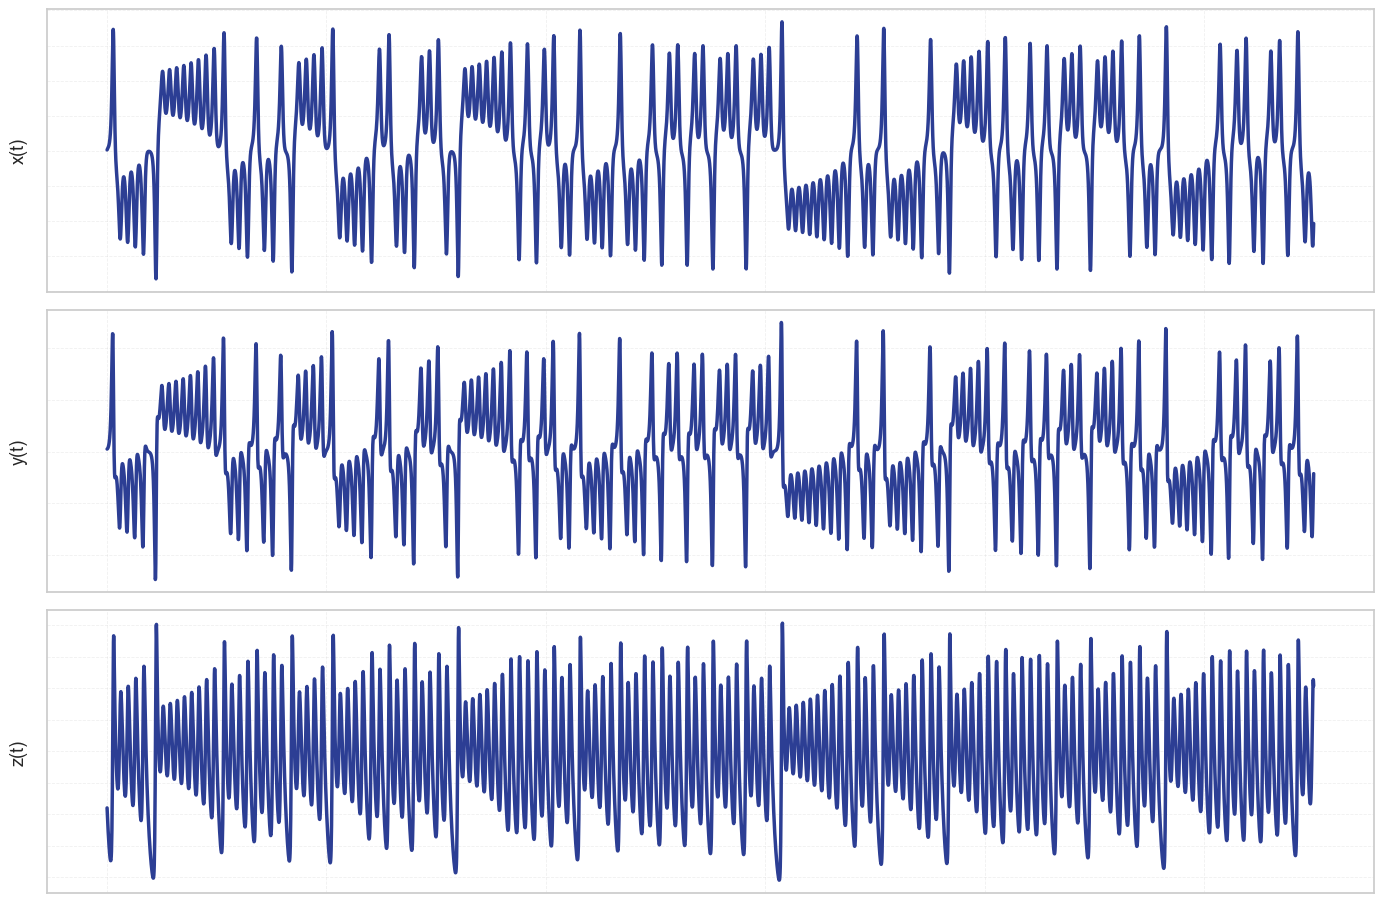

In [ ]:
sns.set(style="whitegrid")

t = np.linspace(0, len(lorenz_trajectory), len(lorenz_trajectory))

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

dims = ['x(t)', 'y(t)', 'z(t)']
line_labels = ['True', 'HypER']
line_styles = ['--', '-']
line_colors = ['#2c3e94', '#e25822']

for i in range(3):
    axes[i].plot(t, lorenz_trajectory[:, i], label=line_labels[0], linewidth=2.5, color=line_colors[0])
    axes[i].set_ylabel(dims[i], fontsize=13)
    # Hide tick labels (units) on x and y axes
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

    # Optional: keep tick marks but adjust size if needed
    axes[i].tick_params(axis='both', which='major', labelsize=0)

    axes[i].grid(True, linestyle='--', linewidth=0.6, alpha=0.3)  # alpha adjusted for grid visibility

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Figures/Trajectories for Train Segment.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = lorenz_trajectory[:-1]
targets = lorenz_trajectory[1:]

In [ ]:
data_size = len(lorenz_trajectory)-1
train_size = 4500
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 5499, train size: 4500, test size: 999


### Rossler System

In [ ]:
tmax = 280.0
dt = 0.02
rossler_t_vals, rossler_trajectory = generate_rossler_data(
    initial_state=[1.0, 0.0, 0.0],
    tmax=tmax,
    dt=dt,
    a=0.2,
    b=0.2,
    c=5.7
)

# Discard first 2,000 points as washout
washout = 2000
rossler_t_vals = rossler_t_vals[washout:]
rossler_trajectory = rossler_trajectory[washout:]

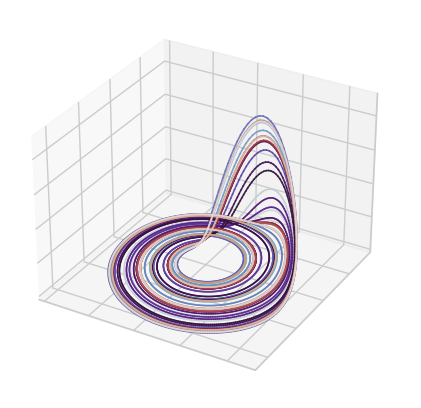

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight(np.linspace(0, 1, len(rossler_trajectory)))

for i in range(len(rossler_trajectory) - 1):
    ax.plot(rossler_trajectory[i:i+2, 0], rossler_trajectory[i:i+2, 1], rossler_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Rossler Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

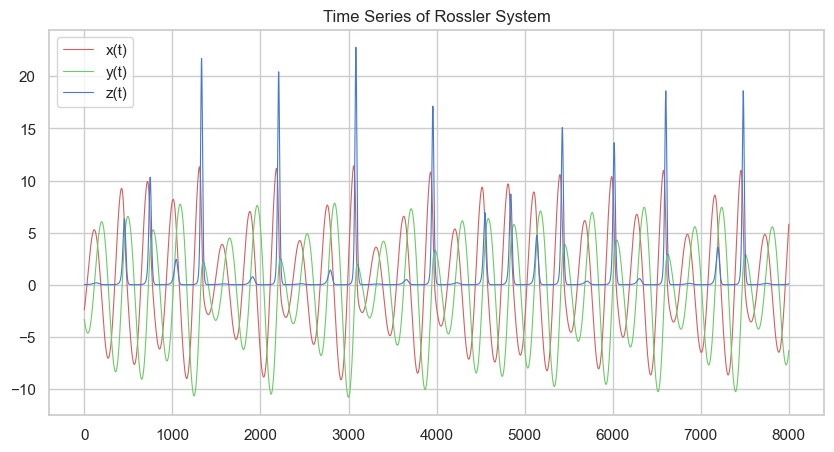

In [ ]:
t = np.linspace(0, len(rossler_trajectory), len(rossler_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, rossler_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, rossler_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, rossler_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Rossler System")
plt.legend()
plt.show()

In [ ]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = rossler_trajectory[:-1]
targets = rossler_trajectory[1:]

In [ ]:
data_size = len(rossler_trajectory)-1
train_size = 4500
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 11999, train size: 4500, test size: 7499


### Chen System

In [ ]:
tmax = 150.0
dt = 0.02
chen_t_vals, chen_trajectory = generate_chen_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=tmax,
    dt=dt,
    a=35.0,
    b=3.0,
    c=28.0
)

# Discard first 2,000 points as washout
washout = 2000
chen_t_vals = chen_t_vals[washout:]
chen_trajectory = chen_trajectory[washout:]

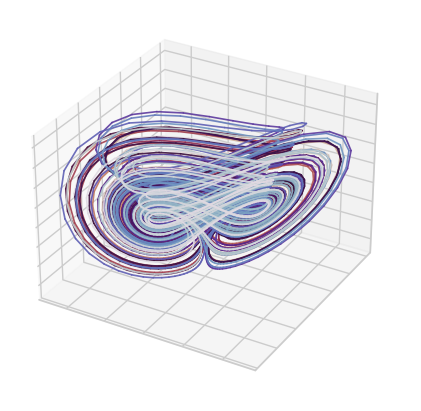

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight_r(np.linspace(0, 1, len(chen_trajectory)))

for i in range(len(chen_trajectory) - 1):
    ax.plot(chen_trajectory[i:i+2, 0], chen_trajectory[i:i+2, 1], chen_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Chen Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

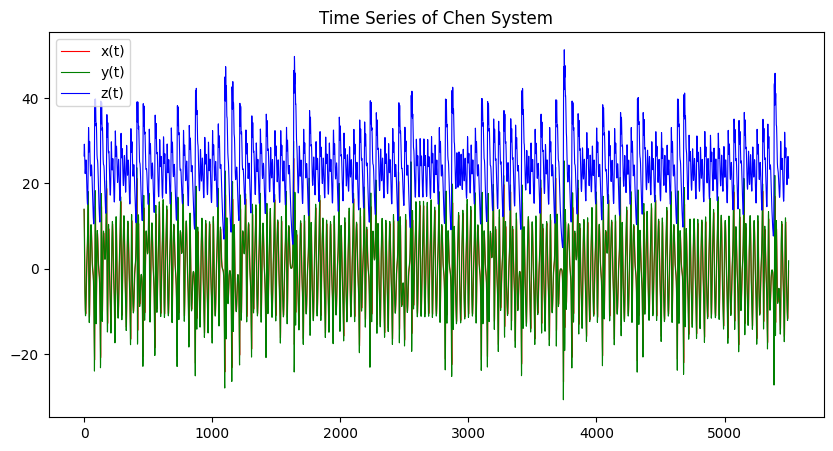

In [ ]:
t = np.linspace(0, len(chen_trajectory), len(chen_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, chen_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, chen_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, chen_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Chen System")
plt.legend()
plt.show()

In [ ]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = chen_trajectory[:-1]
targets = chen_trajectory[1:]

In [ ]:
data_size = len(chen_trajectory)-1
train_size = 4500
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 5499, train size: 4500, test size: 999


### Chua System

In [ ]:
tmax = 154.0
dt = 0.02
chua_t_vals, chua_trajectory = generate_chua_data(
    initial_state=[0.2, 0.0, 0.0], 
    tmax=tmax,
    dt=dt,
    alpha=15.6,
    beta=28.0,
    m0=-1.143,
    m1=-0.714
)

# Discard first 2,000 points as washout
washout = 2200
chua_t_vals = chua_t_vals[washout:]
chua_trajectory = chua_trajectory[washout:]

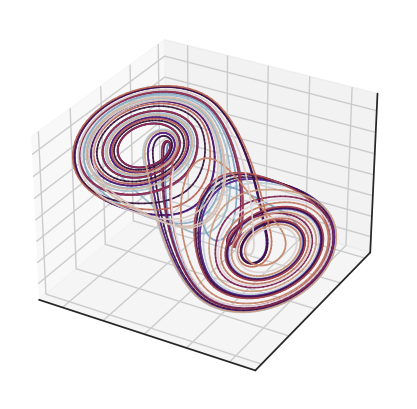

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight(np.linspace(0, 1, len(chua_trajectory)))

for i in range(len(chen_trajectory) - 1):
    ax.plot(chua_trajectory[i:i+2, 0], chua_trajectory[i:i+2, 1], chua_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Chua Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

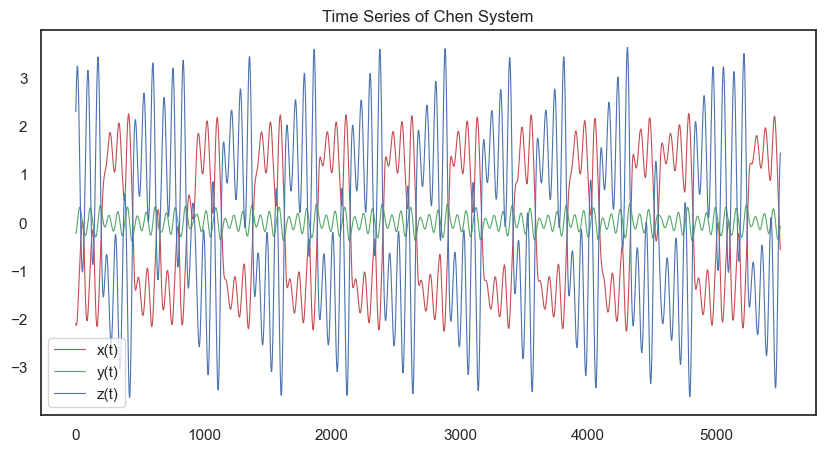

In [ ]:
t = np.linspace(0, len(chua_trajectory), len(chua_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, chua_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, chua_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, chua_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Chen System")
plt.legend()
plt.show()

In [ ]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = chua_trajectory[:-1]
targets = chua_trajectory[1:]

In [ ]:
data_size = len(chua_trajectory)-1
train_size = 4500
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 5499, train size: 4500, test size: 999


## Mackey-Glass System

In [ ]:
tmax = 200.0
dt = 0.02
t_vals, mackey_traj = generate_mackey_glass_data(
    initial_value=0.2,
    tmax=tmax,
    dt=dt,
    beta=0.2,
    gamma=0.1,
    tau=17
)
mackey_traj = np.array(mackey_traj)
mackey_traj.reshape(-1, 1)

# Discard first 2,000 points as washout
washout = 2000
t_vals = t_vals[washout:]
mackey_traj = mackey_traj[washout:]
mackey_traj = create_delay_embedding(mackey_traj, 3)
T_data = len(mackey_traj)
print(f"Data length: {T_data}, from t=0..{tmax} with dt={dt}.")

train_end = 4500
train_input  = mackey_traj[:train_end]
train_target = mackey_traj[1:train_end+1]
test_input   = mackey_traj[train_end:-1]
test_target  = mackey_traj[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps)*dt
print(f"Train size: {len(train_input)}  Test size: {len(test_input)}")

Data length: 7998, from t=0..200.0 with dt=0.02.
Train size: 4500  Test size: 3497


# Teacher-forced Single-step Forecasting

### Models Initialization

In [ ]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=300,
    spectral_radius=1.0,
    connectivity=0.05,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
esn.fit_readout(train_input, train_target, discard=100)
esn_preds = esn.predict(test_input)

In [ ]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
    reservoir_size=300,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
cycle_res.fit_readout(train_input, train_target, discard=100)
cycle_res_preds = cycle_res.predict(test_input)

In [ ]:
crj = CRJRes3D(
    reservoir_size=300,
    jump=15,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
crj.fit_readout(train_input, train_target, discard=100)
crj_preds = crj.predict(test_input)

In [ ]:
sw_esn = SWRes3D(
    reservoir_size=300,
    rewiring_prob=0.1,
    degree=3,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
sw_esn.fit_readout(train_input, train_target, discard=100)
sw_esn_preds = sw_esn.predict(test_input)

In [ ]:
mci_esn = MCIESN3D(
    reservoir_size=150,
    cycle_weight=0.8,
    connect_weight=0.8,
    combine_factor=0.5,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
mci_esn.fit_readout(train_input, train_target, discard=100)
mci_esn_preds = mci_esn.predict(test_input)

In [ ]:
deepesn = DeepESN3D(
    num_layers=3,
    reservoir_size=100,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
deepesn.fit_readout(train_input, train_target, discard=100)
deepesn_preds = deepesn.predict(test_input)

In [ ]:
hypER = HypER3D(
        reservoir_size=300,
        disk_radius=0.99, 
        sigma=0.4,
        top_k=20,
        spectral_radius=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=1002
    )
hypER.fit_readout(train_input, train_target, discard=100)
hypER_preds = hypER.predict(test_input)

### NRMSE Report

In [ ]:
# Define horizons to test
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

In [ ]:
esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)

In [ ]:
# Print results
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'HypER':<15}")
print("-" * 140)

for horizon in horizons:
    print(f"{horizon:<10} {np.mean(esn_nrmse[horizon]):<15.7f} {np.mean(cycle_res_nrmse[horizon]):<15.7f} {np.mean(crj_nrmse[horizon]):<15.7f} {np.mean(sw_esn_nrmse[horizon]):<15.7f} {np.mean(mci_esn_nrmse[horizon]):<15.7f} {np.mean(deepesn_nrmse[horizon]):<15.7f} {np.mean(hypER_nrmse[horizon]):<15.7f}")


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN             SCR             CRJ             SW-ESN          MCI-ESN         DeepESN         HypER          
--------------------------------------------------------------------------------------------------------------------------------------------
200        0.0000707       0.0000284       0.0000373       0.0000293       0.0191931       0.0000716       0.0000016      
400        0.0001485       0.0000778       0.0000930       0.0000510       0.0210047       0.0001946       0.0000031      
600        0.0001280       0.0000666       0.0000798       0.0000453       0.0198433       0.0001659       0.0000027      
800        0.0001143       0.0000593       0.0000712       0.0000423       0.0196266       0.0001476       0.0000025      
1000       0.0001080       0.0000547       0.0000666       0.

In [ ]:
# Plot NRMSE vs Horizon
plot_len=1000
steps = list(range(10, plot_len+1, 10))

plt.figure(figsize=(10, 6))
plt.plot(steps, [np.mean(esn_nrmse[s]) for s in steps], label='ESN')
plt.plot(steps, [np.mean(cycle_res_nrmse[s]) for s in steps], label='SCR')
plt.plot(steps, [np.mean(crj_nrmse[s]) for s in steps], label='CRJ')
plt.plot(steps, [np.mean(sw_esn_nrmse[s]) for s in steps], label='SW-ESN')
plt.plot(steps, [np.mean(mci_esn_nrmse[s]) for s in steps], label='MCI-ESN')
plt.plot(steps, [np.mean(deepesn_nrmse[s]) for s in steps], label='DeepESN')
plt.plot(steps, [np.mean(hypER_nrmse[s]) for s in steps], label='HypER')
plt.xlabel('Prediction Horizon')
plt.ylabel('NRMSE')
plt.title('NRMSE vs. Prediction Horizon (Teacher-forced Single Step Forecasting)')
plt.legend()
plt.savefig("Figures/NRMSE vs. Prediction Horizon (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

### Trajectory Plots

In [ ]:
plot_len = 999
steps = list(range(1, plot_len+1))

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

dims = ['x(t)', 'y(t)', 'z(t)']
for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label='True', linestyle='dashed')
    # axes[i].plot(steps, esn_preds[:plot_len, i], label='ESN')
    # axes[i].plot(steps, cycle_res_preds[:plot_len, i], label='CycleRes')
    axes[i].plot(steps, hypER_preds[:plot_len, i], label='HypER')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

axes[-1].set_xlabel('Time Step')
fig.suptitle('Predicted Trajectories for Test Segment (Teacher-forced Single Step Forecasting)', fontsize=16)
plt.tight_layout()
plt.savefig("Figures/Predicted Trajectories for Test Segment (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='dashed')
ax.plot(hypER_preds[:plot_len,0], hypER_preds[:plot_len,1], hypER_preds[:plot_len,2], label='HypER')
ax.set_title('Lorenz Phase Space Plot for Test Segment (Teacher-forced Single Step Forecasting)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()
plt.savefig("Figures/Lorenz Phase Space Plot for Test Segment (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

# Autoregressive Forecasting

In [ ]:
initial_input = test_input[0]
num_steps = len(test_input)

### Models Initialization

In [ ]:
# Baseline ESN
esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=1002
    )
esn.fit_readout(train_input, train_target, discard=100)
esn_preds = esn.autoregressive_predict(initial_input, num_steps)

In [ ]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=1002
    )
cycle_res.fit_readout(train_input, train_target, discard=100)
cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)

In [ ]:
crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
    seed=1002
)
crj.fit_readout(train_input, train_target, discard=100)
crj_preds = crj.autoregressive_predict(initial_input, num_steps)

In [ ]:
sw_esn = SWRes3D(
    reservoir_size=300,
    rewiring_prob=0.3,
    degree=2,
    spectral_radius=0.99,
    input_scale=0.2,
    leaking_rate=0.7,
    ridge_alpha=1e-5,
    seed=1002
)
sw_esn.fit_readout(train_input, train_target, discard=100)
sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)

In [ ]:
mci_esn = MCIESN3D(
    reservoir_size=300,
    cycle_weight=0.8,
    connect_weight=0.8,
    combine_factor=0.1,
    v1=0.03,
    v2=0.03,
    spectral_radius=0.8,
    leaking_rate=0.8,
    ridge_alpha=1e-5,
    seed=1002
)
mci_esn.fit_readout(train_input, train_target, discard=100)
mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)

In [ ]:
deepesn = DeepESN3D(
    num_layers=3,
    reservoir_size=100,
    spectral_radius=0.99,
    connectivity=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-4,
    seed=1002
)
deepesn.fit_readout(train_input, train_target, discard=100)
deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)

In [ ]:
hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99,
            sigma=0.05,
            top_k=1,
            spectral_radius=0.99,
            input_scale=0.0005,
            leaking_rate=0.8,
            ridge_alpha=0.1,
            seed=1002
        )
hypER.fit_readout(train_input, train_target, discard=100)
hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)

In [ ]:
states, _ = hypER.collect_states(train_input, discard=100)  # shape (T-1000, reservoir_dim)
plot_pca_projection2d(states)
plot_pca_projection3d(states)

In [ ]:
states, _ = esn.collect_states(train_input, discard=100)  # shape (T-1000, reservoir_dim)
plot_pca_projection2d(states)
plot_pca_projection3d(states)

### NRMSE Report

In [ ]:
esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)

# Print results
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 120)
print(f"{'Horizon':<10} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'HypER':<15}")
print("-" * 120)

for horizon in horizons:
    print(f"{horizon:<10} {np.mean(esn_nrmse[horizon]):<15.7f} {np.mean(cycle_res_nrmse[horizon]):<15.7f} {np.mean(crj_nrmse[horizon]):<15.7f} {np.mean(sw_esn_nrmse[horizon]):<15.7f} {np.mean(mci_esn_nrmse[horizon]):<15.7f} {np.mean(deepesn_nrmse[horizon]):<15.7f} {np.mean(hypER_nrmse[horizon]):<15.7f}")


NRMSE for Different Prediction Horizons:
------------------------------------------------------------------------------------------------------------------------
Horizon    ESN             SCR             CRJ             SW-ESN          MCI-ESN         DeepESN         HypER          
------------------------------------------------------------------------------------------------------------------------
200        5.3752404       6.4924094       5.8184212       5.2311921       7.1555852       4.1551704       5.0891612      
400        4.8136317       5.5777411       5.1232891       4.6837077       5.9917392       4.3491214       5.0075224      
600        4.7127337       5.2831020       4.9369602       4.6438776       5.4847639       4.9117630       4.9728585      
800        4.7329918       5.1898550       4.9361741       4.6910203       5.3166996       4.9738114       4.9093787      
1000       4.8984812       5.3196399       5.0915578       4.8432093       5.5226529       4.9293572 

### VPT Report

In [ ]:
lle_lorenz = 0.830
lyapunov_time_lorenz = 1.0 / lle_lorenz
VPT_threshold = 0.3
test_time = np.arange(test_size)*dt

esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time_lorenz, VPT_threshold)

In [ ]:
print(f"{'':<20} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'HypER':<15}")
print("-" * 130)
print(f"{'T_VPT':<20} {esn_VPT:<15.3f} {cycle_res_VPT:<15.3f} {crj_VPT:<15.3f} {sw_esn_VPT:<15.3f} {mci_esn_VPT:<15.3f} {deepesn_VPT:<15.3f} {hypER_VPT:<15.3f}")
print(f"{'T_VPT/T_lambda':<20} {esn_VPT_ratio:<15.3f} {cycle_res_VPT_ratio:<15.3f} {crj_VPT_ratio:<15.3f} {sw_esn_VPT_ratio:<15.3f} {mci_esn_VPT_ratio:<15.3f} {deepesn_VPT_ratio:<15.3f} {hypER_VPT_ratio:<15.3f}")

                     ESN             SCR             CRJ             SW-ESN          MCI-ESN         DeepESN         HypER          
----------------------------------------------------------------------------------------------------------------------------------
T_VPT                1.280           0.000           0.000           0.000           0.000           0.000           0.000          
T_VPT/T_lambda       1.062           0.000           0.000           0.000           0.000           0.000           0.000          


### Adev Report

In [ ]:
cube_size = (4, 4, 4)
esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)

print(f"{'':<20} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'HypER':<15}")
print("-" * 130)
print(f"{'ADev':<20} {esn_adev:<15} {cycle_res_adev:<15} {crj_adev:<15} {sw_esn_adev:<15} {mci_esn_adev:<15} {deepesn_adev:<15} {hypER_adev:<15}")

                     ESN             SCR             CRJ             SW-ESN          MCI-ESN         DeepESN         HypER          
----------------------------------------------------------------------------------------------------------------------------------
ADev                 93              84              77              86              109             104             93             


### PSD Report

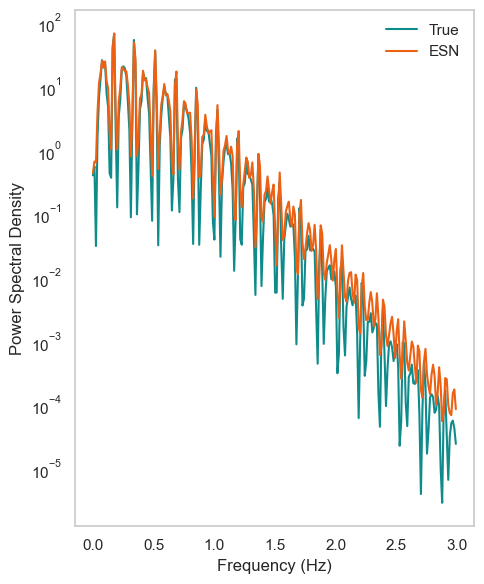

In [ ]:
target_freqs, target_psd = compute_psd(test_target, dt=dt)
esn_freqs, esn_psd = compute_psd(esn_preds, dt=dt)
# cycle_res_freqs, cycle_res_psd = compute_psd(cycle_res_preds, dt=dt)
# crj_freqs, crj_psd = compute_psd(crj_preds, dt=dt)
# sw_esn_freqs, sw_esn_psd = compute_psd(sw_esn_preds, dt=dt)
# mci_esn_freqs, mci_esn_psd = compute_psd(mci_esn_preds, dt=dt)
# deepesn_freqs, deepesn_psd = compute_psd(deepesn_preds, dt=dt)
hypER_freqs, hypER_psd = compute_psd(hypER_preds, dt=dt)


# Plot the PSDs
mask = target_freqs <= 3
plt.figure(figsize=(5, 6))

# True signal
plt.semilogy(target_freqs[mask], target_psd[mask], label='True', linewidth=1.5, color='#108B8B')

# HypER in dark pink
plt.semilogy(esn_freqs[mask], esn_psd[mask], label='ESN', linewidth=1.5, color='#EC6113')
# plt.semilogy(hypER_freqs[mask], hypER_psd[mask], label='HypER', linewidth=1.5, color='#EC6113')

# Labels and formatting
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power Spectral Density', fontsize=12)
# plt.legend(fontsize=11, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.0)
plt.legend(fontsize=11, frameon=False, loc='best')

plt.tight_layout()
plt.savefig("Figures/PSD_vs_Frequency_rossler_esn.png", dpi=600, bbox_inches='tight')
plt.show()



### Trajectory Plots

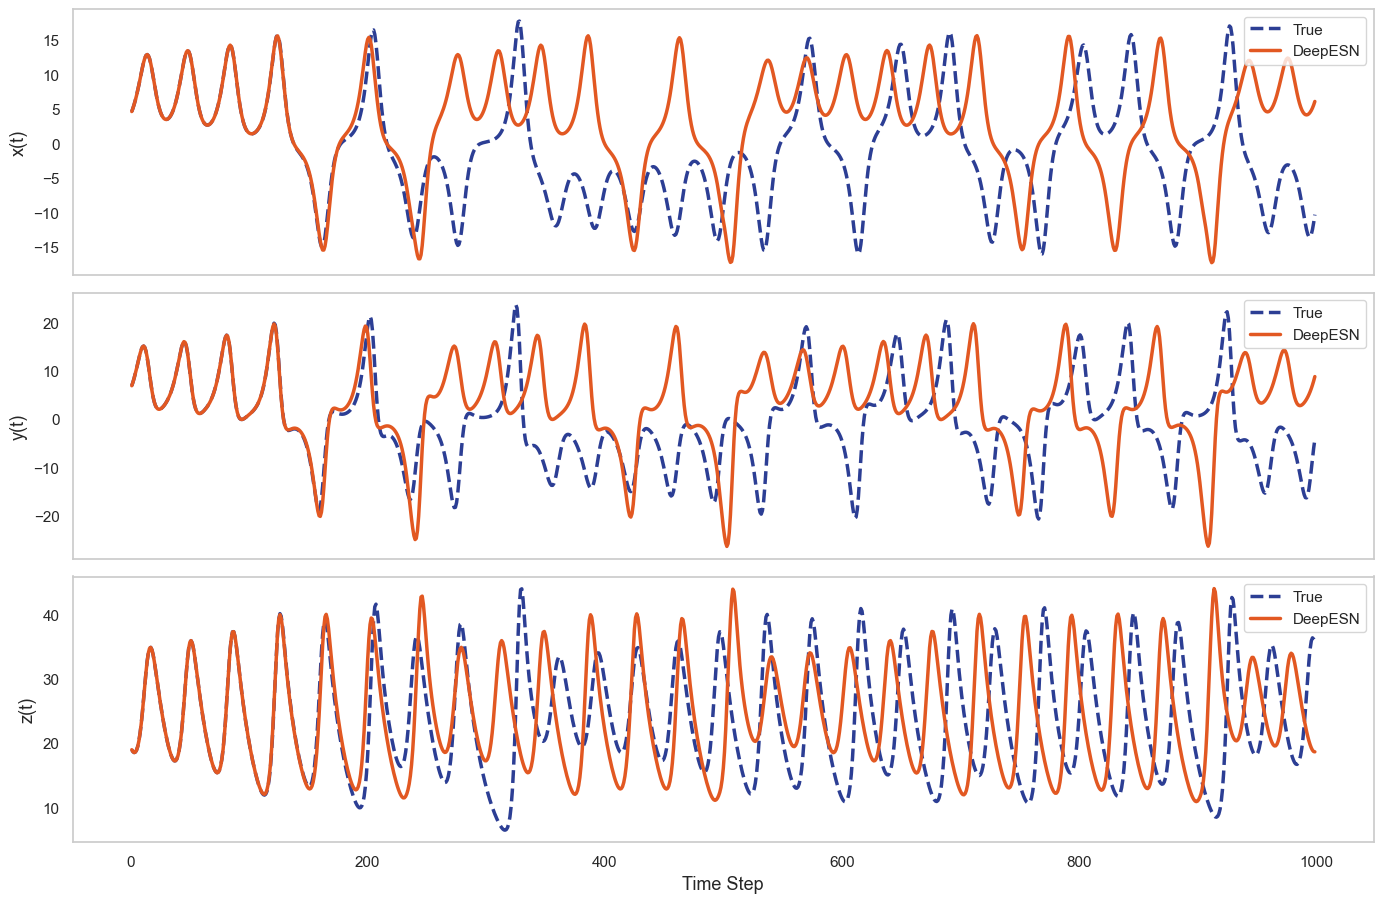

In [ ]:
sns.set(style="whitegrid")

plot_len = 999
steps = list(range(1, plot_len + 1))

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

dims = ['x(t)', 'y(t)', 'z(t)']
line_labels = ['True', 'DeepESN']
line_styles = ['--', '-']
line_colors = ['#2c3e94', '#e25822']

for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label=line_labels[0],
                 linestyle=line_styles[0], linewidth=2.5, color=line_colors[0])
    axes[i].plot(steps, deepesn_preds[:plot_len, i], label=line_labels[1],
                 linestyle=line_styles[1], linewidth=2.5, color=line_colors[1])
    
    axes[i].set_ylabel(dims[i], fontsize=13)
    axes[i].legend(loc='upper right', fontsize=11, frameon=True)
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    axes[i].grid(True, linestyle='--', linewidth=0.6, alpha=0.0)

axes[-1].set_xlabel('Time Step', fontsize=13)
# fig.suptitle('Predicted Trajectories for Test Segment (Autoregressive Forecasting)', 
#              fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Figures/Predicted Trajectories for Lorenz Test Segment - DeepESN.png", dpi=600, bbox_inches='tight')
plt.show()


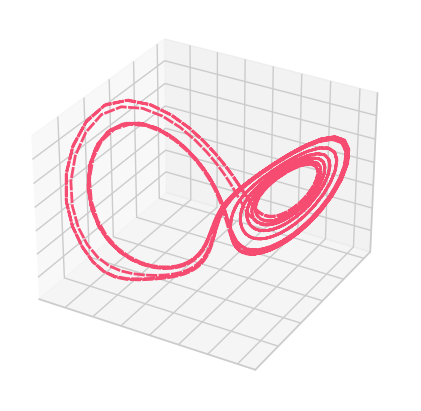

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

# Plot True vs Predicted
line, = ax.plot(deepesn_preds[:plot_len, 0],
                deepesn_preds[:plot_len, 1],
                deepesn_preds[:plot_len, 2],
                label='True Trajectory',
                linewidth=2,
                color='#F64C72')
line.set_dashes([4, 0.5])
# ax.plot(hypER_preds[:plot_len, 0], hypER_preds[:plot_len, 1], hypER_preds[:plot_len, 2],
#         label='HypER Prediction', linewidth=2.5, color=pred_color)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')
# Save the figure
plt.savefig("Figures/Test Segment Lorenz - DeepESN.png", dpi=600, bbox_inches='tight')
plt.show()


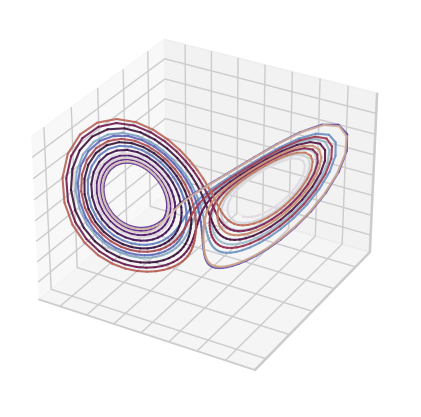

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

# Define the color map based on the number of segments
colors = cm.twilight(np.linspace(0, 1, len(test_target[:plot_len])))

# Plot each segment of the trajectory with its corresponding color
for i in range(plot_len - 1):
    ax.plot(hypER_preds[i:i+2, 0],
            hypER_preds[i:i+2, 1],
            hypER_preds[i:i+2, 2],
            color=colors[i], linewidth=1.5, alpha=0.9)

# Add grid and hide tick marks
ax.grid(True)
ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Lorenz Phase Space — Test Segment (Autoregressive Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

# Experiments

In [ ]:
class EucER3D(BaselineESN3D):
    """
    Hyperbolic Embedding Reservoir (HER) for 3D->3D Lorenz,
    using the Poincaré disc model:
      1) Sample each node from the unit Poincaré disc. 
      2) Compute Hyperbolic Distance dist(u_i, u_j).
      3) Adjacency W_ij = exp( - dist(u_i, u_j)/ sigma ), or 0 to enforce row-sparsity beyond top_k or fraction.
      4) Scale spectral radius to optimum value.
      5) Leaky ESN update with [x, x^2, 1] readout.
    """

    def __init__(self,
                 reservoir_size=300,
                 disk_radius=0.99,              # max radius inside the Poincaré disk (slightly < 1 to avoid boundary
                 sigma=0.5,                     # kernel width for adjacency
                 top_k=0,                       # if >0, keep only top_k largest entries in each row
                 activation_choices=('tanh','relu','sin','linear'),
                 spectral_radius=0.95,
                 input_scale=1.0, 
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        reservoir_size      : number of nodes
        disk_radius         : we sample node positions r<disk_radius < 1 for Poincaré disk
        sigma               : kernel width used in adjacency
        top_k               : if >0, keep only top_k in each row, else 0
        activation_choices  : set of activation types to randomly assign
        spectral_radius     : final adjacency scale
        input_scale         : scale for W_in
        leaking_rate        : ESN leak factor
        ridge_alpha         : readout ridge penalty
        seed                : random seed
        """

        self.reservoir_size = reservoir_size
        self.disk_radius = disk_radius
        self.sigma = sigma
        self.top_k = top_k
        self.activation_choices = activation_choices
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed
        
        np.random.seed(self.seed)
        # Pick angle ~ Uniform (0,2*pi)
        angles = 2.0 * np.pi * np.random.rand(self.reservoir_size)
        r_unif = np.sqrt(np.random.rand(self.reservoir_size)) * self.disk_radius
        positions = np.zeros((self.reservoir_size, 2))
        for i in range(self.reservoir_size):
            positions[i,0] = r_unif[i] * np.cos(angles[i])
            positions[i,1] = r_unif[i] * np.sin(angles[i])
        self.positions = positions


        W = np.zeros((self.reservoir_size, self.reservoir_size))
        for i in range(self.reservoir_size):
            for j in range(self.reservoir_size):
                if i == j:
                    continue
                d_ij = np.linalg.norm(self.positions[i] - self.positions[j])
                val = np.exp(- d_ij / self.sigma)
                W[i, j] = val

        # Row-level sparsity
        if self.top_k > 0:
            for i in range(self.reservoir_size):
                row = W[i,:]
                idx_sorted = np.argsort(row)[::-1]
                keep_count = min(self.top_k, self.reservoir_size)
                row_mask = np.zeros(self.reservoir_size, dtype=bool)
                row_mask[idx_sorted[:keep_count]] = True
                W[i, ~row_mask] = 0.0

        # Scale spectral radius
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        # draw_hyperbolic_reservoir(self.positions, W)

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def _apply_activation(self, act_type, val):
        if act_type=='tanh':
            return np.tanh(val)
        elif act_type=='relu':
            return max(0.0, val)
        elif act_type=='sin':
            return np.sin(val)
        elif act_type=='linear':
            return val
        else:
            return np.tanh(val)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
        """
        pre_activations = self.W @ self.x + self.W_in @ u
        x_new = np.zeros_like(self.x)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activations[i])
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new


In [ ]:
def _rand_dirs(rng, N, d):
    """N random directions on S^{d-1}."""
    v = rng.normal(size=(N, d))
    return v / (np.linalg.norm(v, axis=1, keepdims=True) + 1e-14)


# d = 3  
# F(rho) = 1/4[sinh(2 rho) − 2 rho]   invert via Newton
def sample_poincare_d3(N, disk_radius, seed=None):
    rng = np.random.default_rng(seed)
    rhomax = 2.0 * np.arctanh(disk_radius)
    u = rng.random(N)
    target = u * (np.sinh(2 * rhomax) - 2 * rhomax)

    rho = u * rhomax  # initial guess
    for _ in range(5):
        f  = np.sinh(np.clip(2*rho, -700, 700)) - 2 * rho - target
        fp = 2 * np.cosh(np.clip(2*rho, -700, 700)) - 2
        fp = np.where(np.abs(fp) < 1e-10, 1e-10, fp)
        rho -= f / fp

    r = np.tanh(rho / 2)
    dirs = _rand_dirs(rng, N, 3)
    return dirs * r[:, None]

In [ ]:
def sample_poincare_d4(N, disk_radius, seed=None):
    rng = np.random.default_rng(seed)
    rhomax = 2.0 * np.arctanh(disk_radius)
    u = rng.random(N)
    target = u * ((np.cosh(rhomax))**3 - 3 * np.cosh(rhomax) + 2)

    rho = u * rhomax
    for _ in range(5):
        f = (np.cosh(np.clip(rho, -100, 100)))**3 - 3 * np.cosh(np.clip(rho, -100, 100)) + 2 - target
        fp = 3 * (np.cosh(np.clip(rho, -100, 100)))**2 * np.sinh(np.clip(rho, -100, 100)) - 3 * np.sinh(np.clip(rho, -100, 100))
        fp = np.where(np.abs(fp) < 1e-10, 1e-10, fp)
        rho -= f / fp

    r = np.tanh(rho / 2)
    dirs = _rand_dirs(rng, N, 4)
    return dirs * r[:, None]

In [ ]:
class HypER3Dim(BaselineESN3D):
    """
    Hyperbolic Embedding Reservoir (HER) for 3D->3D Lorenz,
    using the Poincaré disc model:
      1) Sample each node from the unit Poincaré disc. 
      2) Compute Hyperbolic Distance dist(u_i, u_j).
      3) Adjacency W_ij = exp( - dist(u_i, u_j)/ sigma ), or 0 to enforce row-sparsity beyond top_k or fraction.
      4) Scale spectral radius to optimum value.
      5) Leaky ESN update with [x, x^2, 1] readout.
    """

    def __init__(self,
                 reservoir_size=300,
                 disk_radius=0.99,              # max radius inside the Poincaré disk (slightly < 1 to avoid boundary
                 sigma=0.5,                     # kernel width for adjacency
                 top_k=0,                       # if >0, keep only top_k largest entries in each row
                 activation_choices=('tanh','relu','sin','linear'),
                 spectral_radius=0.95,
                 input_scale=1.0, 
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        reservoir_size      : number of nodes
        disk_radius         : we sample node positions r<disk_radius < 1 for Poincaré disk
        sigma               : kernel width used in adjacency
        top_k               : if >0, keep only top_k in each row, else 0
        activation_choices  : set of activation types to randomly assign
        spectral_radius     : final adjacency scale
        input_scale         : scale for W_in
        leaking_rate        : ESN leak factor
        ridge_alpha         : readout ridge penalty
        seed                : random seed
        """

        self.reservoir_size = reservoir_size
        self.disk_radius = disk_radius
        self.sigma = sigma
        self.top_k = top_k
        self.activation_choices = activation_choices
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed
        
        np.random.seed(self.seed)
        # Pick angle ~ Uniform (0,2*pi)
        # angles = 2.0 * np.pi * np.random.rand(self.reservoir_size)
        # r_unif = np.sqrt(np.random.rand(self.reservoir_size)) * self.disk_radius
        # positions = np.zeros((self.reservoir_size, 2))
        # for i in range(self.reservoir_size):
        #     positions[i,0] = r_unif[i] * np.cos(angles[i])
        #     positions[i,1] = r_unif[i] * np.sin(angles[i])
        # self.positions = positions

        self.positions = sample_poincare_d3(reservoir_size, disk_radius, seed)


        W = np.zeros((self.reservoir_size, self.reservoir_size))
        for i in range(self.reservoir_size):
            for j in range(self.reservoir_size):
                if i == j:
                    continue
                d_ij = np.linalg.norm(self.positions[i] - self.positions[j])
                val = np.exp(- d_ij / self.sigma)
                W[i, j] = val

        # Row-level sparsity
        if self.top_k > 0:
            for i in range(self.reservoir_size):
                row = W[i,:]
                idx_sorted = np.argsort(row)[::-1]
                keep_count = min(self.top_k, self.reservoir_size)
                row_mask = np.zeros(self.reservoir_size, dtype=bool)
                row_mask[idx_sorted[:keep_count]] = True
                W[i, ~row_mask] = 0.0

        # Scale spectral radius
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        # draw_hyperbolic_reservoir(self.positions, W)

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def _apply_activation(self, act_type, val):
        if act_type=='tanh':
            return np.tanh(val)
        elif act_type=='relu':
            return max(0.0, val)
        elif act_type=='sin':
            return np.sin(val)
        elif act_type=='linear':
            return val
        else:
            return np.tanh(val)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
        """
        pre_activations = self.W @ self.x + self.W_in @ u
        x_new = np.zeros_like(self.x)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activations[i])
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

In [ ]:
class HypER4Dim(BaselineESN3D):
    """
    Hyperbolic Embedding Reservoir (HER) for 3D->3D Lorenz,
    using the Poincaré disc model:
      1) Sample each node from the unit Poincaré disc. 
      2) Compute Hyperbolic Distance dist(u_i, u_j).
      3) Adjacency W_ij = exp( - dist(u_i, u_j)/ sigma ), or 0 to enforce row-sparsity beyond top_k or fraction.
      4) Scale spectral radius to optimum value.
      5) Leaky ESN update with [x, x^2, 1] readout.
    """

    def __init__(self,
                 reservoir_size=300,
                 disk_radius=0.99,              # max radius inside the Poincaré disk (slightly < 1 to avoid boundary
                 sigma=0.5,                     # kernel width for adjacency
                 top_k=0,                       # if >0, keep only top_k largest entries in each row
                 activation_choices=('tanh','relu','sin','linear'),
                 spectral_radius=0.95,
                 input_scale=1.0, 
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        reservoir_size      : number of nodes
        disk_radius         : we sample node positions r<disk_radius < 1 for Poincaré disk
        sigma               : kernel width used in adjacency
        top_k               : if >0, keep only top_k in each row, else 0
        activation_choices  : set of activation types to randomly assign
        spectral_radius     : final adjacency scale
        input_scale         : scale for W_in
        leaking_rate        : ESN leak factor
        ridge_alpha         : readout ridge penalty
        seed                : random seed
        """

        self.reservoir_size = reservoir_size
        self.disk_radius = disk_radius
        self.sigma = sigma
        self.top_k = top_k
        self.activation_choices = activation_choices
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed
        
        np.random.seed(self.seed)
        # Pick angle ~ Uniform (0,2*pi)
        # angles = 2.0 * np.pi * np.random.rand(self.reservoir_size)
        # r_unif = np.sqrt(np.random.rand(self.reservoir_size)) * self.disk_radius
        # positions = np.zeros((self.reservoir_size, 2))
        # for i in range(self.reservoir_size):
        #     positions[i,0] = r_unif[i] * np.cos(angles[i])
        #     positions[i,1] = r_unif[i] * np.sin(angles[i])
        # self.positions = positions

        self.positions = sample_poincare_d4(reservoir_size, disk_radius, seed)


        W = np.zeros((self.reservoir_size, self.reservoir_size))
        for i in range(self.reservoir_size):
            for j in range(self.reservoir_size):
                if i == j:
                    continue
                d_ij = np.linalg.norm(self.positions[i] - self.positions[j])
                val = np.exp(- d_ij / self.sigma)
                W[i, j] = val

        # Row-level sparsity
        if self.top_k > 0:
            for i in range(self.reservoir_size):
                row = W[i,:]
                idx_sorted = np.argsort(row)[::-1]
                keep_count = min(self.top_k, self.reservoir_size)
                row_mask = np.zeros(self.reservoir_size, dtype=bool)
                row_mask[idx_sorted[:keep_count]] = True
                W[i, ~row_mask] = 0.0

        # Scale spectral radius
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        # draw_hyperbolic_reservoir(self.positions, W)

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def _apply_activation(self, act_type, val):
        if act_type=='tanh':
            return np.tanh(val)
        elif act_type=='relu':
            return max(0.0, val)
        elif act_type=='sin':
            return np.sin(val)
        elif act_type=='linear':
            return val
        else:
            return np.tanh(val)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
        """
        pre_activations = self.W @ self.x + self.W_in @ u
        x_new = np.zeros_like(self.x)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activations[i])
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

## Experiments on Lorenz Dataset under Autoregressive Forecasting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(995, 1025)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [ ]:
nrmse_dict['ESN'] = []
VPT_dict['ESN'] = []
VPT_ratio_dict['ESN'] = []
adev_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['ESN'].append(esn_VPT)
    VPT_ratio_dict['ESN'].append(esn_VPT_ratio)
    esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
    adev_dict['ESN'].append(esn_adev)

In [ ]:
nrmse_dict['SCR'] = []
VPT_dict['SCR'] = []
VPT_ratio_dict['SCR'] = []
adev_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SCR'].append(cycle_res_VPT)
    VPT_ratio_dict['SCR'].append(cycle_res_VPT_ratio)
    cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
    adev_dict['SCR'].append(cycle_res_adev)

In [ ]:
nrmse_dict['CRJ'] = []
VPT_dict['CRJ'] = []
VPT_ratio_dict['CRJ'] = []
adev_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)
    crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['CRJ'].append(crj_VPT)
    VPT_ratio_dict['CRJ'].append(crj_VPT_ratio)
    crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
    adev_dict['CRJ'].append(crj_adev)

In [ ]:
nrmse_dict['SW-ESN'] = []
VPT_dict['SW-ESN'] = []
VPT_ratio_dict['SW-ESN'] = []
adev_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SW-ESN'].append(sw_esn_VPT)
    VPT_ratio_dict['SW-ESN'].append(sw_esn_VPT_ratio)
    sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
    adev_dict['SW-ESN'].append(sw_esn_adev)

In [ ]:
nrmse_dict['MCI-ESN'] = []
VPT_dict['MCI-ESN'] = []
VPT_ratio_dict['MCI-ESN'] = []
adev_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['MCI-ESN'].append(mci_esn_VPT)
    VPT_ratio_dict['MCI-ESN'].append(mci_esn_VPT_ratio)
    mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
    adev_dict['MCI-ESN'].append(mci_esn_adev)

In [ ]:
nrmse_dict['DeepESN'] = []
VPT_dict['DeepESN'] = []
VPT_ratio_dict['DeepESN'] = []
adev_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['DeepESN'].append(deepesn_VPT)
    VPT_ratio_dict['DeepESN'].append(deepesn_VPT_ratio)
    deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
    adev_dict['DeepESN'].append(deepesn_adev)

In [ ]:
nrmse_dict['HypER'] = []
VPT_dict['HypER'] = []
VPT_ratio_dict['HypER'] = []
adev_dict['HypER'] = []

for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.1,
            top_k=40,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-6,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)
    hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['HypER'].append(hypER_VPT)
    VPT_ratio_dict['HypER'].append(hypER_VPT_ratio)
    hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
    adev_dict['HypER'].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

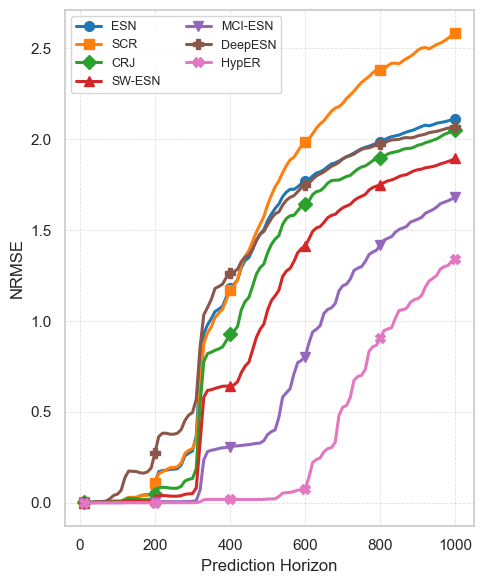

In [ ]:
plot_len = 1000
steps = list(range(10, plot_len + 1, 10))
marker_steps = [10, 200, 400, 600, 800, 1000]

models = {
    'ESN': esn_nrmse,
    'SCR': cycle_res_nrmse,
    'CRJ': crj_nrmse,
    'SW-ESN': sw_esn_nrmse,
    'MCI-ESN': mci_esn_nrmse,
    'DeepESN': deepesn_nrmse,
    'HypER': hypER_nrmse
}

# Assign a unique marker and color style for each
colors = plt.cm.tab10.colors
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

plt.figure(figsize=(5, 6))

for i, (name, data) in enumerate(models.items()):
    values = [np.mean(data[s]) for s in steps]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    values = []

    for horizon in all_horizons:
        # Get all NRMSE values across all runs for this model and this horizon
        all_vals = []
        for run in nrmse_dict[name]:
            all_vals.extend([np.mean(run[horizon])])
        values.append(np.mean(all_vals))

    # Plot with markers so legend also shows them
    plt.plot(steps, values, label=name, linewidth=2.2, color=color,
             marker=marker, markevery=[steps.index(s) for s in marker_steps if s in steps],
             markersize=7)

# Labels and title
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('NRMSE', fontsize=12)
# plt.title('NRMSE vs. Prediction Horizon (Autoregressive Forecasting)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend(fontsize=9, ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig("Figures/NRMSE_vs_Prediction_Horizon_AR_Lorenz.png", dpi=600, bbox_inches='tight')
plt.show()

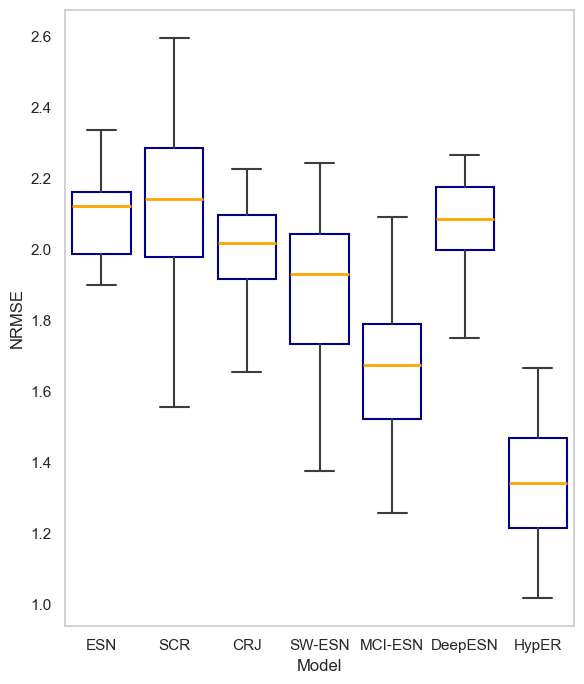

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="muted")

target_horizon = 1000

records = []
for model_name in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    model_vals = [np.mean(entry[target_horizon]) for entry in nrmse_dict[model_name]]
    for val in model_vals:
        records.append({
            "Model": model_name,
            "NRMSE": val
        })

df = pd.DataFrame(records)

plt.figure(figsize=(6, 7))

sns.boxplot(x="Model", y="NRMSE", data=df, showfliers=False, 
            boxprops=dict(color="white", edgecolor="darkblue"),
            medianprops=dict(color="orange", linewidth=2))

plt.xlabel("Model")
plt.ylabel("NRMSE")
plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.0)
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig("Figures/NRMSE_Boxplot_AR_Lorenz.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'DeepESN':<20} {'HypER':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    mean = np.mean(VPT_dict[model])
    std = np.std(VPT_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    mean = np.mean(VPT_ratio_dict[model])
    std = np.std(VPT_ratio_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()


In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'DeepESN':<20} {'HypER':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    values = adev_dict[model]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

## Experiments on Lorenz Dataset in Teacher-forced setting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]


nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

In [ ]:
for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [ ]:
for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [ ]:
for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [ ]:
for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [ ]:
for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [ ]:
for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


In [ ]:
for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.1,
            top_k=40,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-6,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.predict(test_input)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean*10000:.4f} ± {std*10000:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        1.8996 ± 0.2990   1.4125 ± 0.2717   1.5643 ± 0.2405   0.7354 ± 0.0955   0.2557 ± 0.0235   1.8844 ± 0.2839   0.0098 ± 0.0020   
400        2.9158 ± 0.5809   2.7863 ± 0.7634   2.6788 ± 0.3923   1.3756 ± 0.3007   0.4292 ± 0.0451   3.4581 ± 0.6540   0.0286 ± 0.0159   
600        2.6095 ± 0.4832   2.4310 ± 0.6351   2.3650 ± 0.3213   1.2035 ± 0.2473   0.3780 ± 0.0369   3.0275 ± 0.5417   0.0245 ± 0.0132   
800        2.4403 ± 0.4260   2.2120 ± 0.5437   2.1863 ± 0.2711   1.0929 ± 0.2079   0.3487 ± 0.0314   2.7804 ± 0.4631   0.0218

## Experiments on Rossler Dataset under Autoregressive Forecasting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_rossler = 0.071
lyapunov_time_rossler = 1.0 / lle_rossler
lyapunov_time = lyapunov_time_rossler
VPT_threshold = 0.5
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(995, 1025)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [ ]:
nrmse_dict['ESN'] = []
VPT_dict['ESN'] = []
VPT_ratio_dict['ESN'] = []
adev_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.85,
        connectivity=0.001,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['ESN'].append(esn_VPT)
    VPT_ratio_dict['ESN'].append(esn_VPT_ratio)
    esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
    adev_dict['ESN'].append(esn_adev)

In [ ]:
nrmse_dict['SCR'] = []
VPT_dict['SCR'] = []
VPT_ratio_dict['SCR'] = []
adev_dict['SCR'] = []


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.001,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SCR'].append(cycle_res_VPT)
    VPT_ratio_dict['SCR'].append(cycle_res_VPT_ratio)
    cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
    adev_dict['SCR'].append(cycle_res_adev)

In [ ]:
nrmse_dict['CRJ'] = []
VPT_dict['CRJ'] = []
VPT_ratio_dict['CRJ'] = []
adev_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.001,
        jump=5,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)
    crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['CRJ'].append(crj_VPT)
    VPT_ratio_dict['CRJ'].append(crj_VPT_ratio)
    crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
    adev_dict['CRJ'].append(crj_adev)

In [ ]:
nrmse_dict['SW-ESN'] = []
VPT_dict['SW-ESN'] = []
VPT_ratio_dict['SW-ESN'] = []
adev_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.005,
        degree=3,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SW-ESN'].append(sw_esn_VPT)
    VPT_ratio_dict['SW-ESN'].append(sw_esn_VPT_ratio)
    sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
    adev_dict['SW-ESN'].append(sw_esn_adev)

In [ ]:
nrmse_dict['MCI-ESN'] = []
VPT_dict['MCI-ESN'] = []
VPT_ratio_dict['MCI-ESN'] = []
adev_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.3,
        combine_factor=0.5,
        v1=0.05,
        v2=0.05,
        spectral_radius=0.85,
        leaking_rate=0.9,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['MCI-ESN'].append(mci_esn_VPT)
    VPT_ratio_dict['MCI-ESN'].append(mci_esn_VPT_ratio)
    mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
    adev_dict['MCI-ESN'].append(mci_esn_adev)


In [ ]:
nrmse_dict['DeepESN'] = []
VPT_dict['DeepESN'] = []
VPT_ratio_dict['DeepESN'] = []
adev_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.85,
        connectivity=0.0005,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['DeepESN'].append(deepesn_VPT)
    VPT_ratio_dict['DeepESN'].append(deepesn_VPT_ratio)
    deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
    adev_dict['DeepESN'].append(deepesn_adev)

In [ ]:
nrmse_dict['HypER'] = []
VPT_dict['HypER'] = []
VPT_ratio_dict['HypER'] = []
adev_dict['HypER'] = []

for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99,
            sigma=0.05,
            top_k=5,
            spectral_radius=0.85,
            input_scale=0.05,
            leaking_rate=0.8,
            ridge_alpha=1e-5,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)
    hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['HypER'].append(hypER_VPT)
    VPT_ratio_dict['HypER'].append(hypER_VPT_ratio)
    hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
    adev_dict['HypER'].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        0.0036 ± 0.0006   0.0053 ± 0.0023   0.0066 ± 0.0023   0.0063 ± 0.0015   0.0038 ± 0.0017   0.0059 ± 0.0010   0.0007 ± 0.0003   
400        0.0637 ± 0.1875   0.0664 ± 0.1317   0.0319 ± 0.0250   0.0289 ± 0.0215   0.0083 ± 0.0042   0.0374 ± 0.0341   0.0019 ± 0.0008   
600        0.0936 ± 0.2846   0.1222 ± 0.2882   0.0481 ± 0.0387   0.0470 ± 0.0364   0.0113 ± 0.0064   0.0542 ± 0.0583   0.0024 ± 0.0010   
800        0.1603 ± 0.4714   0.2134 ± 0.5601   0.0629 ± 0.0486   0.0700 ± 0.0574   0.0194 ± 0.0245   0.0735 ± 0.0911   0.0033

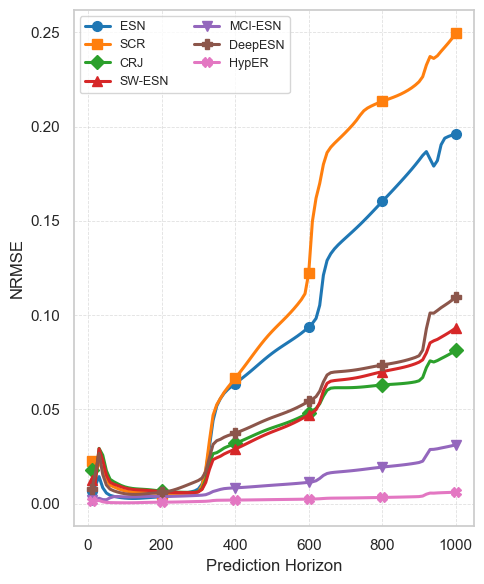

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_len = 1000
steps = list(range(10, plot_len + 1, 10))
marker_steps = [10, 200, 400, 600, 800, 1000]

models = {
    'ESN': esn_nrmse,
    'SCR': cycle_res_nrmse,
    'CRJ': crj_nrmse,
    'SW-ESN': sw_esn_nrmse,
    'MCI-ESN': mci_esn_nrmse,
    'DeepESN': deepesn_nrmse,
    'HypER': hypER_nrmse
}

# Assign a unique marker and color style for each
colors = plt.cm.tab10.colors
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

plt.figure(figsize=(5, 6))

for i, (name, data) in enumerate(models.items()):
    values = [np.mean(data[s]) for s in steps]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    values = []

    for horizon in all_horizons:
        # Get all NRMSE values across all runs for this model and this horizon
        all_vals = []
        for run in nrmse_dict[name]:
            all_vals.extend([np.mean(run[horizon])])
        values.append(np.mean(all_vals))

    # Plot with markers so legend also shows them
    plt.plot(steps, values, label=name, linewidth=2.2, color=color,
             marker=marker, markevery=[steps.index(s) for s in marker_steps if s in steps],
             markersize=7)

# Labels and title
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('NRMSE', fontsize=12)
# plt.title('NRMSE vs. Prediction Horizon (Autoregressive Forecasting)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend(fontsize=9, ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig("Figures/NRMSE_vs_Prediction_Horizon_AR_Rossler.png", dpi=600, bbox_inches='tight')
plt.show()

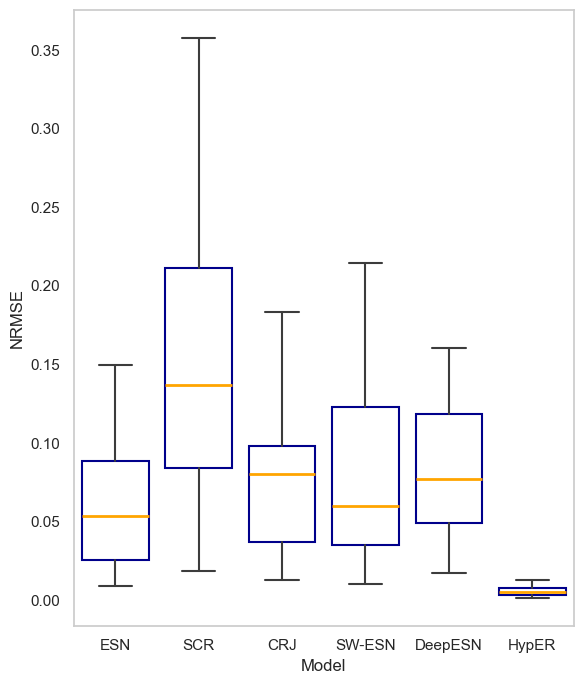

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="muted")

target_horizon = 1000

records = []
for model_name in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'DeepESN', 'HypER']:
    model_vals = [np.mean(entry[target_horizon]) for entry in nrmse_dict[model_name]]
    for val in model_vals:
        records.append({
            "Model": model_name,
            "NRMSE": val
        })

df = pd.DataFrame(records)

plt.figure(figsize=(6, 7))

sns.boxplot(x="Model", y="NRMSE", data=df, showfliers=False, 
            boxprops=dict(color="white", edgecolor="darkblue"),
            medianprops=dict(color="orange", linewidth=2))

plt.xlabel("Model")
plt.ylabel("NRMSE")
plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.0)
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig("Figures/NRMSE_Boxplot_AR_Rossler.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'DeepESN':<20} {'HypER':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    mean = np.mean(VPT_dict[model])
    std = np.std(VPT_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    mean = np.mean(VPT_ratio_dict[model])
    std = np.std(VPT_ratio_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()


                     ESN                  SCR                  CRJ                  SW-ESN               MCI-ESN              DeepESN              HypER               
----------------------------------------------------------------------------------------------------------------------------------------------------------------
T_VPT               48.477 ± 20.04      40.236 ± 24.18      44.362 ± 16.15      43.722 ± 16.48      48.261 ± 9.56       44.752 ± 18.99      72.424 ± 10.75      
T_VPT/T_lambda      3.442 ± 1.42        2.857 ± 1.72        3.150 ± 1.15        3.104 ± 1.17        3.427 ± 0.68        3.177 ± 1.35        5.142 ± 0.76        


In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'DeepESN':<20} {'HypER':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    values = adev_dict[model]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

                     ESN                  SCR                  CRJ                  SW-ESN               MCI-ESN              DeepESN              HypER               
----------------------------------------------------------------------------------------------------------------------------------------------------------------
ADev                4.27 ± 6.23         7.97 ± 6.02         3.03 ± 1.52         3.10 ± 1.87         1.80 ± 1.52         2.10 ± 1.63         1.27 ± 1.17         


## Experiments on Rossler Dataset in Teacher-Forced Setting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

In [ ]:
nrmse_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.85,
        connectivity=0.001,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [ ]:
nrmse_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.001,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [ ]:
nrmse_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.001,
        jump=5,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [ ]:
nrmse_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.005,
        degree=3,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [ ]:
nrmse_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.3,
        combine_factor=0.5,
        v1=0.05,
        v2=0.05,
        spectral_radius=0.85,
        leaking_rate=0.9,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [ ]:
nrmse_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.85,
        connectivity=0.00005,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

In [ ]:
nrmse_dict['HypER'] = []

for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99,
            sigma=0.05,
            top_k=5,
            spectral_radius=0.85,
            input_scale=0.05,
            leaking_rate=0.8,
            ridge_alpha=1e-5,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.predict(test_input)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean*10000:.4f} ± {std*10000:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        0.9231 ± 0.2373   1.9937 ± 0.1939   2.6059 ± 0.2446   2.1212 ± 0.4111   1.1950 ± 0.4164   5.3491 ± 0.5995   0.3083 ± 0.0445   
400        0.7954 ± 0.1926   1.7086 ± 0.1584   2.1328 ± 0.1823   1.7554 ± 0.3084   1.7890 ± 0.6158   4.7256 ± 0.5313   0.2892 ± 0.0584   
600        0.7707 ± 0.1997   1.6123 ± 0.1408   2.0085 ± 0.1545   1.6425 ± 0.2645   1.5919 ± 0.5456   4.5042 ± 0.4586   0.2654 ± 0.0512   
800        0.8084 ± 0.1775   1.7565 ± 0.1537   2.2597 ± 0.1820   1.8216 ± 0.3055   1.7582 ± 0.5515   4.6048 ± 0.4612   0.3229

## Experiments on Chen Dataset under Autoregressive Forecasting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_chen = 0.830
lyapunov_time_chen = 1.0 / lle_chen
lyapunov_time = lyapunov_time_chen
VPT_threshold = 0.3
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(995, 1025)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [ ]:
nrmse_dict['ESN'] = []
VPT_dict['ESN'] = []
VPT_ratio_dict['ESN'] = []
adev_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['ESN'].append(esn_VPT)
    VPT_ratio_dict['ESN'].append(esn_VPT_ratio)
    esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
    adev_dict['ESN'].append(esn_adev)

In [ ]:
nrmse_dict['SCR'] = []
VPT_dict['SCR'] = []
VPT_ratio_dict['SCR'] = []
adev_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-2,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SCR'].append(cycle_res_VPT)
    VPT_ratio_dict['SCR'].append(cycle_res_VPT_ratio)
    cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
    adev_dict['SCR'].append(cycle_res_adev)

In [ ]:
nrmse_dict['CRJ'] = []
VPT_dict['CRJ'] = []
VPT_ratio_dict['CRJ'] = []
adev_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-2,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)
    crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['CRJ'].append(crj_VPT)
    VPT_ratio_dict['CRJ'].append(crj_VPT_ratio)
    crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
    adev_dict['CRJ'].append(crj_adev)

In [ ]:
nrmse_dict['SW-ESN'] = []
VPT_dict['SW-ESN'] = []
VPT_ratio_dict['SW-ESN'] = []
adev_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-3,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SW-ESN'].append(sw_esn_VPT)
    VPT_ratio_dict['SW-ESN'].append(sw_esn_VPT_ratio)
    sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
    adev_dict['SW-ESN'].append(sw_esn_adev)

In [ ]:
nrmse_dict['MCI-ESN'] = []
VPT_dict['MCI-ESN'] = []
VPT_ratio_dict['MCI-ESN'] = []
adev_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['MCI-ESN'].append(mci_esn_VPT)
    VPT_ratio_dict['MCI-ESN'].append(mci_esn_VPT_ratio)
    mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
    adev_dict['MCI-ESN'].append(mci_esn_adev)

In [ ]:
nrmse_dict['DeepESN'] = []
VPT_dict['DeepESN'] = []
VPT_ratio_dict['DeepESN'] = []
adev_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['DeepESN'].append(deepesn_VPT)
    VPT_ratio_dict['DeepESN'].append(deepesn_VPT_ratio)
    deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
    adev_dict['DeepESN'].append(deepesn_adev)

In [ ]:
nrmse_dict['HypER'] = []
VPT_dict['HypER'] = []
VPT_ratio_dict['HypER'] = []
adev_dict['HypER'] = []

for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.2,
            top_k=10,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-9,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)
    hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['HypER'].append(hypER_VPT)
    VPT_ratio_dict['HypER'].append(hypER_VPT_ratio)
    hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
    adev_dict['HypER'].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        1.6613 ± 0.7941   1.6366 ± 0.4114   1.6308 ± 1.0914   1.5562 ± 0.2400   1.1049 ± 0.3810   1.8560 ± 0.5049   0.0259 ± 0.0244   
400        2.3164 ± 1.0948   2.3481 ± 0.8614   2.3479 ± 1.6356   2.0338 ± 0.2648   1.8995 ± 0.3987   2.5622 ± 0.7545   0.8992 ± 0.3583   
600        2.6037 ± 1.1631   2.7002 ± 1.1561   2.5733 ± 1.8155   2.2990 ± 0.1988   2.1915 ± 0.3383   2.7744 ± 0.9136   1.5692 ± 0.3497   
800        2.6638 ± 1.1837   2.9429 ± 1.3532   2.6705 ± 1.8522   2.3862 ± 0.2291   2.3021 ± 0.2791   2.8746 ± 0.9632   1.9195

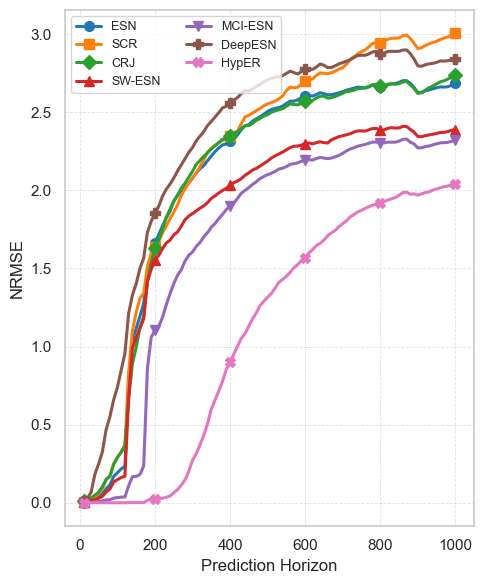

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_len = 1000
steps = list(range(10, plot_len + 1, 10))
marker_steps = [10, 200, 400, 600, 800, 1000]

models = {
    'ESN': esn_nrmse,
    'SCR': cycle_res_nrmse,
    'CRJ': crj_nrmse,
    'SW-ESN': sw_esn_nrmse,
    'MCI-ESN': mci_esn_nrmse,
    'DeepESN': deepesn_nrmse,
    'HypER': hypER_nrmse
}

# Assign a unique marker and color style for each
colors = plt.cm.tab10.colors
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

plt.figure(figsize=(5, 6))

for i, (name, data) in enumerate(models.items()):
    values = [np.mean(data[s]) for s in steps]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    values = []

    for horizon in all_horizons:
        # Get all NRMSE values across all runs for this model and this horizon
        all_vals = []
        for run in nrmse_dict[name]:
            all_vals.extend([np.mean(run[horizon])])
        values.append(np.mean(all_vals))

    # Plot with markers so legend also shows them
    plt.plot(steps, values, label=name, linewidth=2.2, color=color,
             marker=marker, markevery=[steps.index(s) for s in marker_steps if s in steps],
             markersize=7)

# Labels and title
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('NRMSE', fontsize=12)
# plt.title('NRMSE vs. Prediction Horizon (Autoregressive Forecasting)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend(fontsize=9, ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig("Figures/NRMSE_vs_Prediction_Horizon_AR_Chen.png", dpi=600, bbox_inches='tight')
plt.show()

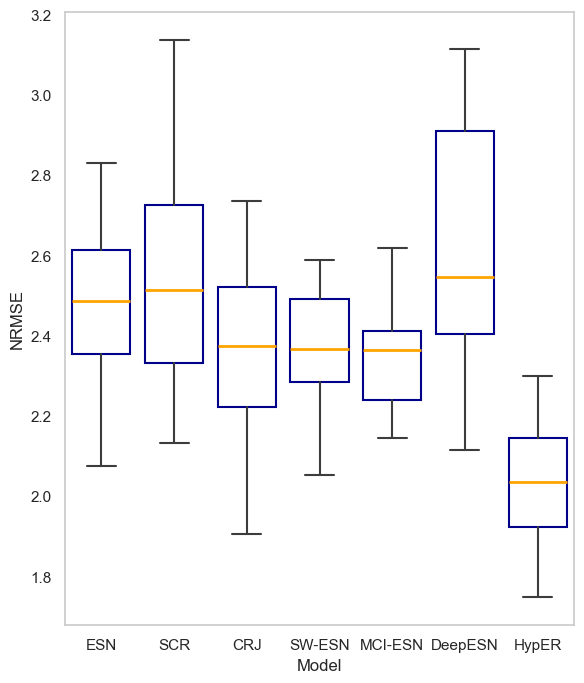

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="muted")

target_horizon = 1000

records = []
for model_name in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    model_vals = [np.mean(entry[target_horizon]) for entry in nrmse_dict[model_name]]
    for val in model_vals:
        records.append({
            "Model": model_name,
            "NRMSE": val
        })

df = pd.DataFrame(records)

plt.figure(figsize=(6, 7))

sns.boxplot(x="Model", y="NRMSE", data=df, showfliers=False, 
            boxprops=dict(color="white", edgecolor="darkblue"),
            medianprops=dict(color="orange", linewidth=2))

plt.xlabel("Model")
plt.ylabel("NRMSE")
plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.0)
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig("Figures/NRMSE_Boxplot_AR_Chen.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'DeepESN':<20} {'HypER':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    mean = np.mean(VPT_dict[model])
    std = np.std(VPT_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    mean = np.mean(VPT_ratio_dict[model])
    std = np.std(VPT_ratio_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()


                     ESN                  SCR                  CRJ                  SW-ESN               MCI-ESN              DeepESN              HypER               
----------------------------------------------------------------------------------------------------------------------------------------------------------------
T_VPT               2.417 ± 0.41        2.344 ± 0.49        2.330 ± 0.40        2.538 ± 0.22        3.167 ± 0.53        1.969 ± 0.72        6.105 ± 0.85        
T_VPT/T_lambda      2.006 ± 0.34        1.946 ± 0.41        1.934 ± 0.33        2.107 ± 0.18        2.628 ± 0.44        1.635 ± 0.60        5.067 ± 0.70        


In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'DeepESN':<20} {'HypER':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'HypER']:
    values = adev_dict[model]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

                     ESN                  SCR                  CRJ                  SW-ESN               MCI-ESN              DeepESN              HypER               
----------------------------------------------------------------------------------------------------------------------------------------------------------------
ADev                121.77 ± 20.48      130.20 ± 25.69      101.23 ± 17.04      104.87 ± 14.99      97.57 ± 14.77       138.37 ± 40.28      80.60 ± 9.25        


## Experiments on Chen Dataset in Teacher-Forced Setting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

In [ ]:
nrmse_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-9,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [ ]:
nrmse_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-9,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [ ]:
nrmse_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-9,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [ ]:
nrmse_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-9,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [ ]:
nrmse_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-9,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [ ]:
nrmse_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-9,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

In [ ]:
nrmse_dict['HypER'] = []

for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.2,
            top_k=10,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-9,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.predict(test_input)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean*10000:.4f} ± {std*10000:.4f}".ljust(18), end="")
    print()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_len = 1000
steps = list(range(10, plot_len + 1, 10))
marker_steps = [10, 200, 400, 600, 800, 1000]

models = {
    'ESN': esn_nrmse,
    'SCR': cycle_res_nrmse,
    'CRJ': crj_nrmse,
    'SW-ESN': sw_esn_nrmse,
    'MCI-ESN': mci_esn_nrmse,
    'DeepESN': deepesn_nrmse,
    'HypER': hypER_nrmse
}

# Assign a unique marker and color style for each
colors = plt.cm.tab10.colors
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

plt.figure(figsize=(5, 6))

for i, (name, data) in enumerate(models.items()):
    values = [np.mean(data[s]) for s in steps]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    values = []

    for horizon in all_horizons:
        # Get all NRMSE values across all runs for this model and this horizon
        all_vals = []
        for run in nrmse_dict[name]:
            all_vals.extend([np.mean(run[horizon])])
        values.append(np.mean(all_vals))

    # Plot with markers so legend also shows them
    plt.plot(steps, values, label=name, linewidth=2.2, color=color,
             marker=marker, markevery=[steps.index(s) for s in marker_steps if s in steps],
             markersize=7)

# Labels and title
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('NRMSE', fontsize=12)
# plt.title('NRMSE vs. Prediction Horizon (Autoregressive Forecasting)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend(fontsize=9, ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig("Figures/NRMSE_vs_Prediction_Horizon_TF_Chen.png", dpi=600, bbox_inches='tight')
plt.show()

## Experiments on Chua Dataset in Teacher-Forced Setting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

In [ ]:
nrmse_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.6,
        connectivity=0.3,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [ ]:
nrmse_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.7,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [ ]:
nrmse_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.7,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [ ]:
nrmse_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [ ]:
nrmse_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.08,
        v2=0.08,
        spectral_radius=0.99,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [ ]:
nrmse_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=0.5,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

In [ ]:
nrmse_dict['HypER'] = []

for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99,
            sigma=0.4,
            top_k=60,
            spectral_radius=0.9,
            input_scale=0.9,
            leaking_rate=0.8,
            ridge_alpha=1e-9,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.predict(test_input)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean*10000:.4f} ± {std*10000:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        13.8035 ± 0.1938  13.5475 ± 0.1996  15.1684 ± 0.1935  14.3335 ± 0.6491  9.7472 ± 0.3295   10.1497 ± 2.1081  6.2185 ± 0.6540   
400        15.1457 ± 0.1914  15.3644 ± 0.2263  16.6796 ± 0.1801  16.1305 ± 0.6441  13.4237 ± 1.0293  16.5536 ± 5.9645  9.9356 ± 1.8790   
600        15.9751 ± 0.1817  16.2945 ± 0.2131  17.5255 ± 0.2071  17.3768 ± 0.6440  15.7155 ± 1.4067  19.1823 ± 5.2401  11.9119 ± 2.3407  
800        15.3668 ± 0.1756  15.5799 ± 0.1943  16.8523 ± 0.1939  16.6317 ± 0.6016  15.5763 ± 1.2959  17.7481 ± 4.1196  11.164

## Experiments on Mackey Glass Dataset in Teacher-Forced Setting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

initial_input = test_input[0]
num_steps = len(test_input)
test_time = time_test

seeds = range(995, 1025)

nrmse_dict = defaultdict(list)

In [ ]:
nrmse_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [ ]:
nrmse_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.95,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [ ]:
nrmse_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.95,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [ ]:
nrmse_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.1,
        degree=6,
        spectral_radius=0.95,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [ ]:
nrmse_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.95,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [ ]:
nrmse_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.95,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

In [ ]:
nrmse_dict['HypER'] = []

for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99,
            sigma=0.1,
            top_k=20,
            spectral_radius=0.95,
            input_scale=0.5,
            leaking_rate=0.8,
            ridge_alpha=1e-4,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.predict(test_input)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HypER':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean*10000:.4f} ± {std*10000:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        5.5661 ± 1.3796   6.9932 ± 1.5362   5.0097 ± 0.6247   5.8431 ± 0.5661   19.1107 ± 4.0490  8.6601 ± 5.0794   3.1238 ± 1.9327   
400        6.2835 ± 1.4160   6.6683 ± 1.2692   6.2317 ± 0.6278   7.4746 ± 0.7737   16.3728 ± 3.5216  8.4966 ± 4.1926   2.6762 ± 1.6936   
600        6.6987 ± 1.3977   6.9751 ± 1.2262   6.7004 ± 0.6669   8.3971 ± 0.9325   18.0263 ± 3.6055  8.8932 ± 4.1969   2.8812 ± 1.7718   
800        7.2707 ± 1.5154   7.3480 ± 1.2577   7.3534 ± 0.7506   9.4275 ± 1.0753   19.3275 ± 3.6537  9.4067 ± 4.3209   3.0088

## Ablation over the underlying manifold geometry and dimension used for reservoir node embedding

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(995, 1025)

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [ ]:
for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.1,
            top_k=40,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-6,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)
    hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['HypER'].append(hypER_VPT)
    VPT_ratio_dict['HypER'].append(hypER_VPT_ratio)
    hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
    adev_dict['HypER'].append(hypER_adev)

In [ ]:
for seed in seeds:
    eucER = EucER3D(
            reservoir_size=300,
            disk_radius=0.99,
            sigma=0.1,
            top_k=40,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-6,
            seed=seed
        )
    eucER.fit_readout(train_input, train_target, discard=100)
    eucER_preds = eucER.autoregressive_predict(initial_input, num_steps)
    eucER_nrmse = evaluate_nrmse(eucER_preds, test_target, all_horizons)
    nrmse_dict['EucER'].append(eucER_nrmse)
    eucER_VPT, eucER_VPT_ratio = compute_valid_prediction_time(test_target, eucER_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['EucER'].append(eucER_VPT)
    VPT_ratio_dict['EucER'].append(eucER_VPT_ratio)
    eucER_adev = compute_attractor_deviation(eucER_preds, test_target, cube_size)
    adev_dict['EucER'].append(eucER_adev)

In [ ]:
for seed in seeds:
    hypER3 = HypER3Dim(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.1,
            top_k=40,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-6,
            seed=seed
        )
    hypER3.fit_readout(train_input, train_target, discard=100)
    hypER3_preds = hypER3.autoregressive_predict(initial_input, num_steps)
    hypER3_nrmse = evaluate_nrmse(hypER3_preds, test_target, all_horizons)
    nrmse_dict['HypER3'].append(hypER3_nrmse)
    hypER3_VPT, hypER3_VPT_ratio = compute_valid_prediction_time(test_target, hypER3_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['HypER3'].append(hypER3_VPT)
    VPT_ratio_dict['HypER3'].append(hypER3_VPT_ratio)
    hypER3_adev = compute_attractor_deviation(hypER3_preds, test_target, cube_size)
    adev_dict['HypER3'].append(hypER3_adev)

In [ ]:
for seed in seeds:
    hypER4 = HypER4Dim(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.4,
            top_k=20,
            spectral_radius=0.99,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-6,
            seed=seed
        )
    hypER4.fit_readout(train_input, train_target, discard=100)
    hypER4_preds = hypER4.autoregressive_predict(initial_input, num_steps)
    hypER4_nrmse = evaluate_nrmse(hypER4_preds, test_target, all_horizons)
    nrmse_dict['HypER4'].append(hypER4_nrmse)
    hypER4_VPT, hypER4_VPT_ratio = compute_valid_prediction_time(test_target, hypER4_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['HypER4'].append(hypER4_VPT)
    VPT_ratio_dict['HypER4'].append(hypER4_VPT_ratio)
    hypER4_adev = compute_attractor_deviation(hypER4_preds, test_target, cube_size)
    adev_dict['HypER4'].append(hypER4_adev)


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'HypER':<17} {'EucER':<17} {'HypER3':<17} {'HypER4':<17}")
print("-" * 140)


for horizon in horizons:
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]
    eucER_vals = [np.mean(eucER_nrmse[horizon]) for eucER_nrmse in nrmse_dict['EucER']]
    hypER3_vals = [np.mean(hypER3_nrmse[horizon]) for hypER3_nrmse in nrmse_dict['HypER3']]
    hypER4_vals = [np.mean(hypER4_nrmse[horizon]) for hypER4_nrmse in nrmse_dict['HypER4']]

    print(f"{horizon:<10}", end=" ")
    for vals in [hypER_vals, eucER_vals, hypER3_vals, hypER4_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    HypER             EucER             HypER3            HypER4           
--------------------------------------------------------------------------------------------------------------------------------------------
200        0.0002 ± 0.0002   0.0005 ± 0.0003   0.0004 ± 0.0004   0.0005 ± 0.0004   
400        0.0176 ± 0.0156   0.0356 ± 0.0237   0.0294 ± 0.0266   0.0373 ± 0.0289   
600        0.0702 ± 0.0648   0.1533 ± 0.1348   0.1289 ± 0.1384   0.1749 ± 0.1834   
800        0.9623 ± 0.2802   1.0444 ± 0.2567   1.0176 ± 0.2437   1.0990 ± 0.2426   
1000       1.3540 ± 0.2675   1.3981 ± 0.2004   1.3702 ± 0.1897   1.4639 ± 0.1795   


In [ ]:
print(f"{'':<20} {'HypER':<20} {'EucER':<20} {'HypER3':<20} {'HypER4':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for model in ['HypER', 'EucER', 'HypER3', 'HypER4']:
    mean = np.mean(VPT_dict[model])
    std = np.std(VPT_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for model in ['HypER', 'EucER', 'HypER3', 'HypER4']:
    mean = np.mean(VPT_ratio_dict[model])
    std = np.std(VPT_ratio_dict[model])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()


                     HypER                EucER                HypER3               HypER4              
----------------------------------------------------------------------------------------------------------------------------------------------------------------
T_VPT               13.201 ± 1.44       12.365 ± 0.97       12.367 ± 1.08       11.952 ± 1.12       
T_VPT/T_lambda      11.947 ± 1.30       11.191 ± 0.88       11.192 ± 0.97       10.817 ± 1.01       


In [ ]:
print(f"{'':<20} {'HypER':<20} {'EucER':<20} {'HypER3':<20} {'HypER4':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for model in ['HypER', 'EucER', 'HypER3', 'HypER4']:
    values = adev_dict[model]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

                     HypER                EucER                HypER3               HypER4              
----------------------------------------------------------------------------------------------------------------------------------------------------------------
ADev                23.43 ± 11.45       23.13 ± 7.53        21.37 ± 6.92        22.03 ± 6.37        


## Ablation over kernel width

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

for sigma in [0.05, 0.1, 0.2, 0.3, 0.5]:
    for seed in (range(995, 1025)):
        hypER = HypER3D(
                reservoir_size=300,
                disk_radius=0.99, 
                sigma=sigma,
                top_k=40,
                spectral_radius=0.99,
                input_scale=0.2,
                leaking_rate=0.8,
                ridge_alpha=1e-6,
                seed=seed
            )
        hypER.fit_readout(train_input, train_target, discard=100)
        hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
        hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
        nrmse_dict[sigma].append(hypER_nrmse)
        hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
        VPT_dict[sigma].append(hypER_VPT)
        VPT_ratio_dict[sigma].append(hypER_VPT_ratio)
        hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
        adev_dict[sigma].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'0.05':<17} {'0.1':<17} {'0.2':<17} {'0.3':<17} {'0.5':<17}")
print("-" * 140)


for horizon in horizons:
    vals1 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.05]]
    vals2 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.1]]
    vals3 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.2]]
    vals4 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.3]]
    vals5 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.5]]

    print(f"{horizon:<10}", end=" ")
    for vals in [vals1, vals2, vals3, vals4, vals5]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print()

print(f"{'':<20} {'0.05':<20} {'0.1':<20} {'0.2':<20} {'0.3':<20} {'0.5':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for sigma in [0.05, 0.1, 0.2, 0.3, 0.5]:
    mean = np.mean(VPT_dict[sigma])
    std = np.std(VPT_dict[sigma])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for sigma in [0.05, 0.1, 0.2, 0.3, 0.5]:
    mean = np.mean(VPT_ratio_dict[sigma])
    std = np.std(VPT_ratio_dict[sigma])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()
print()

print(f"{'':<20} {'0.05':<20} {'0.1':<20} {'0.2':<20} {'0.3':<20} {'0.5':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for sigma in [0.05, 0.1, 0.2, 0.3, 0.5]:
    values = adev_dict[sigma]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

## Ablation over row-level sparsity

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

for top_k in [10, 20, 40, 60, 80]:
    for seed in (range(995, 1025)):
        hypER = HypER3D(
                reservoir_size=300,
                disk_radius=0.99, 
                sigma=0.1,
                top_k=top_k,
                spectral_radius=0.99,
                input_scale=0.2,
                leaking_rate=0.8,
                ridge_alpha=1e-6,
                seed=seed
            )
        hypER.fit_readout(train_input, train_target, discard=100)
        hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
        hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
        nrmse_dict[top_k].append(hypER_nrmse)
        hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
        VPT_dict[top_k].append(hypER_VPT)
        VPT_ratio_dict[top_k].append(hypER_VPT_ratio)
        hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
        adev_dict[top_k].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'10':<17} {'20':<17} {'40':<17} {'60':<17} {'80':<17}")
print("-" * 140)


for horizon in horizons:
    vals1 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[10]]
    vals2 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[20]]
    vals3 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[40]]
    vals4 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[60]]
    vals5 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[80]]

    print(f"{horizon:<10}", end=" ")
    for vals in [vals1, vals2, vals3, vals4, vals5]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print()

print(f"{'':<20} {'10':<20} {'20':<20} {'40':<20} {'60':<20} {'80':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for top_k in [10, 20, 40, 60, 80]:
    mean = np.mean(VPT_dict[top_k])
    std = np.std(VPT_dict[top_k])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for top_k in [10, 20, 40, 60, 80]:
    mean = np.mean(VPT_ratio_dict[top_k])
    std = np.std(VPT_ratio_dict[top_k])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'':<20} {'10':<20} {'20':<20} {'40':<20} {'60':<20} {'80':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for top_k in [10, 20, 40, 60, 80]:
    values = adev_dict[top_k]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

## Ablation over spectral radius

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

for spectral_radius in [0.7, 0.9, 0.99, 1.05]:
    for seed in (range(995, 1025)):
        hypER = HypER3D(
                reservoir_size=300,
                disk_radius=0.99, 
                sigma=0.1,
                top_k=40,
                spectral_radius=spectral_radius,
                input_scale=0.2,
                leaking_rate=0.8,
                ridge_alpha=1e-6,
                seed=seed
            )
        hypER.fit_readout(train_input, train_target, discard=100)
        hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
        hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
        nrmse_dict[spectral_radius].append(hypER_nrmse)
        hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
        VPT_dict[spectral_radius].append(hypER_VPT)
        VPT_ratio_dict[spectral_radius].append(hypER_VPT_ratio)
        hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
        adev_dict[spectral_radius].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'0.5':<17} {'0.7':<17} {'0.9':<17} {'0.99':<17} {'1.05':<17} {'1.1':<17}")
print("-" * 140)


for horizon in horizons:
    vals1 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.7]]
    vals2 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.9]]
    vals3 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.99]]
    vals4 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1.05]]

    print(f"{horizon:<10}", end=" ")
    for vals in [vals1, vals2, vals3, vals4, vals5]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print()

print(f"{'':<20} {'0.7':<20} {'0.9':<20} {'0.99':<20} {'1.05':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for spectral_radius in [0.7, 0.9, 0.99, 1.05]:
    mean = np.mean(VPT_dict[spectral_radius])
    std = np.std(VPT_dict[spectral_radius])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for spectral_radius in [0.7, 0.9, 0.99, 1.05]:
    mean = np.mean(VPT_ratio_dict[spectral_radius])
    std = np.std(VPT_ratio_dict[spectral_radius])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()
print()

print(f"{'':<20} {'0.7':<20} {'0.9':<20} {'0.99':<20} {'1.05':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for spectral_radius in [0.7, 0.9, 0.99, 1.05]:
    values = adev_dict[spectral_radius]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

## Ablation over input scale

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(995, 1025)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

for input_scale in [0.10, 0.20, 0.30, 0.50, 0.80, 1.0]:
    for seed in seeds:
        hypER = HypER3D(
                reservoir_size=300,
                disk_radius=0.99, 
                sigma=0.1,
                top_k=40,
                spectral_radius=0.99,
                input_scale=input_scale,
                leaking_rate=0.8,
                ridge_alpha=1e-6,
                seed=seed
            )
        hypER.fit_readout(train_input, train_target, discard=100)
        hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
        hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
        nrmse_dict[input_scale].append(hypER_nrmse)
        hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
        VPT_dict[input_scale].append(hypER_VPT)
        VPT_ratio_dict[input_scale].append(hypER_VPT_ratio)
        hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
        adev_dict[input_scale].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'0.1':<17} {'0.2':<17} {'0.3':<17} {'0.5':<17} {'0.8':<17} {'1.0':<17}")
print("-" * 140)


for horizon in horizons:
    vals1 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.10]]
    vals2 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.20]]
    vals3 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.30]]
    vals4 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.50]]
    vals5 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.80]]
    vals6 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1.0]]

    print(f"{horizon:<10}", end=" ")
    for vals in [vals1, vals2, vals3, vals4, vals5, vals6]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print()

print(f"{'':<20} {'0.1':<20} {'0.2':<20} {'0.3':<20} {'0.5':<20} {'0.8':<20} {'1.0':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for input_scale in [0.10, 0.20, 0.30, 0.50, 0.80, 1.0]:
    mean = np.mean(VPT_dict[input_scale])
    std = np.std(VPT_dict[input_scale])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for input_scale in [0.10, 0.20, 0.30, 0.50, 0.80, 1.0]:
    mean = np.mean(VPT_ratio_dict[input_scale])
    std = np.std(VPT_ratio_dict[input_scale])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()
print()

print(f"{'':<20} {'0.1':<20} {'0.2':<20} {'0.3':<20} {'0.5':<20} {'0.8':<20} {'1.0':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for input_scale in [0.10, 0.20, 0.30, 0.50, 0.80, 1.0]:
    values = adev_dict[input_scale]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

## Ablation over leak rate

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(995, 1025)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

for leak_rate in [0.5, 0.7, 0.8, 0.9, 1.0]:
    for seed in seeds:
        hypER = HypER3D(
                reservoir_size=300,
                disk_radius=0.99, 
                sigma=0.1,
                top_k=40,
                spectral_radius=0.99,
                input_scale=0.2,
                leaking_rate=leak_rate,
                ridge_alpha=1e-6,
                seed=seed
            )
        hypER.fit_readout(train_input, train_target, discard=100)
        hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
        hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
        nrmse_dict[leak_rate].append(hypER_nrmse)
        hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
        VPT_dict[leak_rate].append(hypER_VPT)
        VPT_ratio_dict[leak_rate].append(hypER_VPT_ratio)
        hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
        adev_dict[leak_rate].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'0.5':<17} {'0.7':<17} {'0.8':<17} {'0.9':<17} {'1.0':<17}")
print("-" * 140)


for horizon in horizons:
    vals1 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.5]]
    vals2 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.7]]
    vals3 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.8]]
    vals4 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[0.9]]
    vals5 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1.0]]

    print(f"{horizon:<10}", end=" ")
    for vals in [vals1, vals2, vals3, vals4, vals5]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print()

print(f"{'':<20} {'0.5':<20} {'0.7':<20} {'0.8':<20} {'0.9':<20} {'1.0':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for leak_rate in [0.5, 0.7, 0.8, 0.9, 1.0]:
    mean = np.mean(VPT_dict[leak_rate])
    std = np.std(VPT_dict[leak_rate])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for leak_rate in [0.5, 0.7, 0.8, 0.9, 1.0]:
    mean = np.mean(VPT_ratio_dict[leak_rate])
    std = np.std(VPT_ratio_dict[leak_rate])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()
print()

print(f"{'':<20} {'0.5':<20} {'0.7':<20} {'0.8':<20} {'0.9':<20} {'1.0':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for leak_rate in [0.5, 0.7, 0.8, 0.9, 1.0]:
    values = adev_dict[leak_rate]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

## Ablation over regularization coefficient

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(995, 1025)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

for ridge_alpha in [1e-7, 1e-6, 1e-5]:
    for seed in seeds:
        hypER = HypER3D(
                reservoir_size=300,
                disk_radius=0.99, 
                sigma=0.1,
                top_k=40,
                spectral_radius=0.99,
                input_scale=0.2,
                leaking_rate=0.8,
                ridge_alpha=ridge_alpha,
                seed=seed
            )
        hypER.fit_readout(train_input, train_target, discard=100)
        hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
        hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
        nrmse_dict[ridge_alpha].append(hypER_nrmse)
        hypER_VPT, hypER_VPT_ratio = compute_valid_prediction_time(test_target, hypER_preds, test_time, lyapunov_time, VPT_threshold)
        VPT_dict[ridge_alpha].append(hypER_VPT)
        VPT_ratio_dict[ridge_alpha].append(hypER_VPT_ratio)
        hypER_adev = compute_attractor_deviation(hypER_preds, test_target, cube_size)
        adev_dict[ridge_alpha].append(hypER_adev)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'1e-8':<17} {'1e-7':<17} {'1e-6':<17} {'1e-5':<17} {'1e-4':<17}")
print("-" * 140)


for horizon in horizons:
    vals1 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1e-8]]
    vals2 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1e-7]]
    vals3 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1e-6]]
    vals4 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1e-5]]
    vals5 = [np.mean(nrmse[horizon]) for nrmse in nrmse_dict[1e-4]]

    print(f"{horizon:<10}", end=" ")
    for vals in [vals1, vals2, vals3, vals4, vals5]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print()

print(f"{'':<20} {'1e-8':<20} {'1e-7':<20} {'1e-6':<20} {'1e-5':<20} {'1e-4':<20}")
print("-" * 160)

print(f"{'T_VPT':<20}", end='')
for ridge_alpha in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]:
    mean = np.mean(VPT_dict[ridge_alpha])
    std = np.std(VPT_dict[ridge_alpha])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for ridge_alpha in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]:
    mean = np.mean(VPT_ratio_dict[ridge_alpha])
    std = np.std(VPT_ratio_dict[ridge_alpha])
    print(f"{mean:.3f} ± {std:.2f}".ljust(20), end='')
print()
print()

print(f"{'':<20} {'1e-8':<20} {'1e-7':<20} {'1e-6':<20} {'1e-5':<20} {'1e-4':<20}")
print("-" * 160)

print(f"{'ADev':<20}", end='')
for ridge_alpha in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]:
    values = adev_dict[ridge_alpha]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.2f} ± {mad:.2f}".ljust(20), end='')
print()

# MIT-BIH Dataset

In [ ]:
import wfdb

# Download and load record and annotations for patient #100
record = wfdb.rdrecord('100', sampfrom=0, sampto=25002, pn_dir='mitdb')  # first 20,000 samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=25002, pn_dir='mitdb')

In [ ]:
# Get input signal u(t) from the first channel
u = record.p_signal[:, 0] 
u

array([-0.145, -0.145, -0.145, ..., -0.41 , -0.415, -0.425])

In [ ]:
# Normalize input
u_min = np.min(u)
u_max = np.max(u)
u_norm = (u - u_min) / (u_max - u_min)

In [ ]:
fs = record.fs  # sampling frequency (should be 360 Hz)
t_vals = np.arange(len(u_norm)) / fs

In [ ]:
emb_dim = 3
# inputs = u_norm
inputs = create_delay_embedding(u_norm, emb_dim)

# Create target array (heartbeat locations)
targets = np.zeros(len(u_norm))
targets[annotation.sample] = 1  # mark annotations as 1 (heartbeat)
targets = create_delay_embedding(targets, emb_dim)

In [ ]:
data_size = len(inputs)
train_size = 15000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size+1:]
test_target = targets[train_size+1:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 25000, train size: 15000, test size: 9999


In [ ]:
all_horizons = [200, 500, 1000]


nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        input_scale=0.5,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CR3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.8,
        input_scale=0.3,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJ3D(
        reservoir_size=300,
        jump=20,
        spectral_radius=0.92,
        input_scale=0.6,
        leaking_rate=0.4,
        ridge_alpha=1e-7,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sws_esn = SW3DSegregated(
        reservoir_size=300,
        edges_per_node=2,
        input_scale=0.4,
        rewiring_probability=1,
        spectral_radius=0.8,
        seed=seed
    )
    sws_esn.fit_readout(train_input, train_target, discard=5000)
    sws_esn_preds = sws_esn.predict_open(test_input)
    sws_esn_nrmse = evaluate_nrmse(sws_esn_preds, test_target, all_horizons)
    nrmse_dict['SWS-ESN'].append(sws_esn_nrmse)

for seed in seeds:
    swr_esn = SW3DRandom(
        reservoir_size=300,
        edges_per_node=4,
        input_scale=0.2,
        rewiring_probability=0.2,
        spectral_radius=0.8,
        seed=seed
    )
    swr_esn.fit_readout(train_input, train_target, discard=5000)
    swr_esn_preds = swr_esn.predict_open(test_input)
    swr_esn_nrmse = evaluate_nrmse(swr_esn_preds, test_target, all_horizons)
    nrmse_dict['SWR-ESN'].append(swr_esn_nrmse)


for seed in seeds:
    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.6,
        connect_weight=1,
        input_scale=0.5,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        combine_factor=0.3,
        seed=seed,
        v1=0.4, v2=0.4
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict_open_loop(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    hfr = HFRRes3D(
            n_levels=8,      
            cells_per_level=[5, 15, 25, 30, 35, 40, 45, 105],
            spectral_radius=0.9,
            input_scale=0.2,
            leaking_rate=0.9,
            ridge_alpha=1e-8,
            seed=seed
        )
    hfr.fit_readout(train_input, train_target, discard=5000)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, all_horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SWS-ESN':<17} {'SWR-ESN':<17} {'MCI-ESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in all_horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sws_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SWS-ESN']]
    swr_vals  = [np.mean(swr_esn_nrmse[horizon]) for swr_esn_nrmse in nrmse_dict['SWR-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    # deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sws_vals, swr_vals, mci_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()



NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
1000       1.4987 ± 0.2916   1.3069 ± 0.1143   1.2053 ± 0.1060   1.3972 ± 0.1451   1.1230 ± 0.0121   1.6553 ± 0.2547   0.7492 ± 0.1166   


# Sunspot Dataset

In [ ]:
import pandas as pd
file_path = 'dataset/SN_m_tot_V2.0.csv'

df = pd.read_csv(file_path, sep=';', header = None)
df

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3310,2024,11,2024.873,152.5,20.9,681,0
3311,2024,12,2024.958,154.5,25.6,572,0
3312,2025,1,2025.042,137.0,23.3,670,0
3313,2025,2,2025.122,154.6,23.3,655,0


In [ ]:
data = df.iloc[:, 3].values
dt = 1
dataset_size = len(data)
data = create_delay_embedding(data, 3)
print(f"Dataset size: {dataset_size}")

# Train/Test Split
train_end = 2000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}\nTest size: {len(test_input)}")

Dataset size: 3315
Train size: 2000
Test size: 1312


In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 500, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        input_scale=0.5,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CR3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.8,
        input_scale=0.3,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJ3D(
        reservoir_size=300,
        jump=20,
        spectral_radius=0.92,
        input_scale=0.6,
        leaking_rate=0.4,
        ridge_alpha=1e-7,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sws_esn = SW3DSegregated(
        reservoir_size=300,
        edges_per_node=2,
        input_scale=0.4,
        rewiring_probability=1,
        spectral_radius=0.8,
        seed=seed
    )
    sws_esn.fit_readout(train_input, train_target, discard=5000)
    sws_esn_preds = sws_esn.predict_open(test_input)
    sws_esn_nrmse = evaluate_nrmse(sws_esn_preds, test_target, all_horizons)
    nrmse_dict['SWS-ESN'].append(sws_esn_nrmse)

for seed in seeds:
    swr_esn = SW3DRandom(
        reservoir_size=300,
        edges_per_node=4,
        input_scale=0.2,
        rewiring_probability=0.2,
        spectral_radius=0.8,
        seed=seed
    )
    swr_esn.fit_readout(train_input, train_target, discard=5000)
    swr_esn_preds = swr_esn.predict_open(test_input)
    swr_esn_nrmse = evaluate_nrmse(swr_esn_preds, test_target, all_horizons)
    nrmse_dict['SWR-ESN'].append(swr_esn_nrmse)


for seed in seeds:
    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.6,
        connect_weight=1,
        input_scale=0.5,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        combine_factor=0.3,
        seed=seed,
        v1=0.4, v2=0.4
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict_open_loop(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    hfr = HFRRes3D(
            n_levels=8,      
            cells_per_level=[5, 15, 25, 30, 35, 40, 45, 105],
            spectral_radius=0.9,
            input_scale=0.2,
            leaking_rate=0.9,
            ridge_alpha=1e-8,
            seed=seed
        )
    hfr.fit_readout(train_input, train_target, discard=5000)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, all_horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SWS-ESN':<17} {'SWR-ESN':<17} {'MCI-ESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sws_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SWS-ESN']]
    swr_vals  = [np.mean(swr_esn_nrmse[horizon]) for swr_esn_nrmse in nrmse_dict['SWR-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    # deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hfr_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sws_vals, swr_vals, mci_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        5.1681 ± 2.5483   6.0723 ± 1.1326   4.8475 ± 1.4909   4.2787 ± 1.0273   2.4635 ± 0.1145   1.3174 ± 0.1826   0.8515 ± 0.1008   
400        5.0651 ± 1.3399   5.6918 ± 0.5887   4.2263 ± 1.2638   3.3983 ± 0.6059   2.0151 ± 0.0702   1.1023 ± 0.1138   0.6964 ± 0.0424   
600        4.7200 ± 1.0571   6.4209 ± 1.6932   4.0023 ± 0.6231   3.3421 ± 0.6611   1.8867 ± 0.0466   1.0375 ± 0.1171   0.6130 ± 0.0343   
800        4.1884 ± 0.9370   5.6912 ± 1.4899   3.5737 ± 0.5606   2.9863 ± 0.5822   1.9369 ± 0.0502   0.9951 ± 0.1003   0.6037

In [ ]:
all_horizons = list(range(5, 300, 5))

initial_input = test_input[0]
num_steps = len(test_input)
nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        input_scale=0.5,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CR3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.8,
        input_scale=0.3,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJ3D(
        reservoir_size=300,
        jump=20,
        spectral_radius=0.92,
        input_scale=0.6,
        leaking_rate=0.4,
        ridge_alpha=1e-7,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sws_esn = SW3DSegregated(
        reservoir_size=300,
        edges_per_node=2,
        input_scale=0.4,
        rewiring_probability=1,
        spectral_radius=0.8,
        seed=seed
    )
    sws_esn.fit_readout(train_input, train_target, discard=5000)
    sws_esn_preds = sws_esn.predict_open(test_input)
    sws_esn_nrmse = evaluate_nrmse(sws_esn_preds, test_target, all_horizons)
    nrmse_dict['SWS-ESN'].append(sws_esn_nrmse)

for seed in seeds:
    swr_esn = SW3DRandom(
        reservoir_size=300,
        edges_per_node=4,
        input_scale=0.2,
        rewiring_probability=0.2,
        spectral_radius=0.8,
        seed=seed
    )
    swr_esn.fit_readout(train_input, train_target, discard=5000)
    swr_esn_preds = swr_esn.predict_open(test_input)
    swr_esn_nrmse = evaluate_nrmse(swr_esn_preds, test_target, all_horizons)
    nrmse_dict['SWR-ESN'].append(swr_esn_nrmse)


for seed in seeds:
    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.6,
        connect_weight=1,
        input_scale=0.5,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        combine_factor=0.3,
        seed=seed,
        v1=0.4, v2=0.4
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict_open_loop(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    hfr = HFRRes3D(
            n_levels=8,      
            cells_per_level=[5, 15, 25, 30, 35, 40, 45, 105],
            spectral_radius=0.9,
            input_scale=0.2,
            leaking_rate=0.9,
            ridge_alpha=1e-8,
            seed=seed
        )
    hfr.fit_readout(train_input, train_target, discard=5000)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, all_horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SWS-ESN':<17} {'SWR-ESN':<17} {'MCI-ESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sws_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SWS-ESN']]
    swr_vals  = [np.mean(swr_esn_nrmse[horizon]) for swr_esn_nrmse in nrmse_dict['SWR-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    hfr_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sws_vals, swr_vals, mci_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

# Sante Fe Dataset

In [ ]:
import pandas as pd

file_path = 'dataset/santa-fe-time-series/b1.txt'

df = pd.read_csv(file_path, header=None, sep=' ')
df

In [ ]:
# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())

In [ ]:
data = df.iloc[:7503, 0].values
chosen_system = "SantaFe"
dt = 1
T_data = len(data)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split
train_end = 4500
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}  \nTest size: {len(test_input)}")


In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 500, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        input_scale=0.5,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CR3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.8,
        input_scale=0.3,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJ3D(
        reservoir_size=300,
        jump=20,
        spectral_radius=0.92,
        input_scale=0.6,
        leaking_rate=0.4,
        ridge_alpha=1e-7,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sws_esn = SW3DSegregated(
        reservoir_size=300,
        edges_per_node=2,
        input_scale=0.4,
        rewiring_probability=1,
        spectral_radius=0.8,
        seed=seed
    )
    sws_esn.fit_readout(train_input, train_target, discard=5000)
    sws_esn_preds = sws_esn.predict_open(test_input)
    sws_esn_nrmse = evaluate_nrmse(sws_esn_preds, test_target, all_horizons)
    nrmse_dict['SWS-ESN'].append(sws_esn_nrmse)

for seed in seeds:
    swr_esn = SW3DRandom(
        reservoir_size=300,
        edges_per_node=4,
        input_scale=0.2,
        rewiring_probability=0.2,
        spectral_radius=0.8,
        seed=seed
    )
    swr_esn.fit_readout(train_input, train_target, discard=5000)
    swr_esn_preds = swr_esn.predict_open(test_input)
    swr_esn_nrmse = evaluate_nrmse(swr_esn_preds, test_target, all_horizons)
    nrmse_dict['SWR-ESN'].append(swr_esn_nrmse)


for seed in seeds:
    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.6,
        connect_weight=1,
        input_scale=0.5,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        combine_factor=0.3,
        seed=seed,
        v1=0.4, v2=0.4
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict_open_loop(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    hfr = HFRRes3D(
            n_levels=8,      
            cells_per_level=[5, 15, 25, 30, 35, 40, 45, 105],
            spectral_radius=0.9,
            input_scale=0.2,
            leaking_rate=0.9,
            ridge_alpha=1e-8,
            seed=seed
        )
    hfr.fit_readout(train_input, train_target, discard=5000)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, all_horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SWS-ESN':<17} {'SWR-ESN':<17} {'MCI-ESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sws_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SWS-ESN']]
    swr_vals  = [np.mean(swr_esn_nrmse[horizon]) for swr_esn_nrmse in nrmse_dict['SWR-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    hfr_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sws_vals, swr_vals, mci_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

In [ ]:
all_horizons = list(range(5, 30, 5))

initial_input = test_input[0]
num_steps = len(test_input)
nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.95,

        connectivity=0.05,
        input_scale=0.1,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.9,
        input_scale=0.4,
        leaking_rate=0.6,
        ridge_alpha=1e-3,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=5,
        spectral_radius=0.95,
        input_scale=0.4,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.2,
        degree=6,
        spectral_radius=0.95,
        input_scale=0.3,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)


for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.01,
        connect_weight=0.1,
        combine_factor=0.1,
        v1=0.003,
        v2=0.003,
        spectral_radius=0.95,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.85,
        input_scale=0.2,
        leaking_rate=0.9,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


for seed in seeds:
    hypER = HypER3D(
            reservoir_size=300,
            disk_radius=0.99, 
            sigma=0.1,
            top_k=15,
            spectral_radius=0.95,
            input_scale=0.2,
            leaking_rate=0.8,
            ridge_alpha=1e-6,
            seed=seed
        )
    hypER.fit_readout(train_input, train_target, discard=100)
    hypER_preds = hypER.autoregressive_predict(initial_input, num_steps)
    hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    nrmse_dict['HypER'].append(hypER_nrmse)


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<25} {'SCR':<25} {'CRJ':<25} {'SW-ESN':<25} {'MCI-ESN':<25} {'DeepESN':<25} {'HypER':<25}")
print("-" * 140)

horizons = [5, 10, 15]
for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, hypER_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(25), end="")
    print()